In [49]:
import pandas as pd
import re
import string
from nltk.tokenize import word_tokenize
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load image filenames and captions from CSV files
train_data = pd.read_csv('/kaggle/input/abcabc/train.csv')
test_data = pd.read_csv('/kaggle/input/abcabc/test.csv')
val_data = pd.read_csv('/kaggle/input/abcabc/val.csv')

# Initialize word_to_idx and idx_to_word with special tokens
special_tokens = ['<start>', '<end>', '<unk>', '<pad>']
word_to_idx = {token: index for index, token in enumerate(special_tokens)}
idx_to_word = {index: token for index, token in enumerate(special_tokens)}

# Initialize the set of vocabulary words with special tokens
vocab = set(special_tokens)

def preprocess_caption(caption):
    caption = caption.lower()
    caption = re.sub(r'[^a-z0-9\s]', '', caption)
    caption_tokens = ['<start>'] + [word for word in word_tokenize(caption.strip()) if word not in string.punctuation] + ['<end>']
    caption_tokens = caption_tokens + ['<pad>']  # Add the '<pad>' token
    return caption_tokens

# Process captions to build the vocabulary
for caption in train_data['caption']:
    caption_tokens = preprocess_caption(caption)
    vocab.update(caption_tokens)

# Update word_to_idx and idx_to_word with words from the vocabulary
for word in vocab:
    if word not in word_to_idx:
        index = len(word_to_idx)
        word_to_idx[word] = index
        idx_to_word[index] = word

vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

# Preprocess images
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CaptionDataset(Dataset):
    def __init__(self, data, image_dir, transform=None):
        self.data = data
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_id = self.data.iloc[idx, 1]
        caption = self.data.iloc[idx, 2]
        image_path = os.path.join(self.image_dir, f"{image_id}")  # Added .jpg extension
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        caption_ids = [word_to_idx.get(word, word_to_idx['<unk>']) for word in preprocess_caption(caption)]
        caption_ids = [word_to_idx['<start>']] + caption_ids + [word_to_idx['<end>']]

        # Pad the caption with <pad> token to a fixed length
        max_length = 50  # Set a maximum length for captions
        padded_caption = caption_ids + [word_to_idx['<pad>']] * (max_length - len(caption_ids))
        padded_caption = padded_caption[:max_length]  # Truncate if the length exceeds the maximum
        padded_caption = torch.tensor(padded_caption)

        return image, padded_caption

# Create datasets
train_dataset = CaptionDataset(train_data, '/kaggle/input/abcabc/train/train', transform=image_transforms)
test_dataset = CaptionDataset(test_data, '/kaggle/input/abcabc/test/test', transform=image_transforms)
val_dataset = CaptionDataset(val_data, '/kaggle/input/abcabc/val/val', transform=image_transforms)

# # CNN Encoder
# cnn_encoder = models.resnet18(pretrained=True)
# cnn_encoder.fc = nn.Identity()  # Remove the final classification layer
# cnn_encoder = cnn_encoder.to(device)  # Move the encoder to the specified device

# CNN Encoder
cnn_encoder = models.resnet18(pretrained=True)
for param in cnn_encoder.parameters():
    param.requires_grad = False  # Freeze all layers initially

# Fine-tune the last few layers
for param in cnn_encoder.layer4.parameters():
    param.requires_grad = True  # Unfreeze last layer for fine-tuning

cnn_encoder.fc = nn.Identity()  # Remove the final classification layer
cnn_encoder = cnn_encoder.to(device)  # Move the encoder to the specified device

# Determine the size of the CNN encoder output
with torch.no_grad():
    encoded_image_size = cnn_encoder(torch.randn(1, 3, 224, 224).to(device)).shape[1]
print(f"Encoded image size: {encoded_image_size}")

# class RNNDecoder(nn.Module):
#     def __init__(self, embed_size, hidden_size, vocab_size, num_layers, encoded_image_size):
#         super(RNNDecoder, self).__init__()
#         self.embed = nn.Embedding(vocab_size, embed_size).to(device)
#         self.lstm_input_size = embed_size + encoded_image_size
#         self.lstm = nn.LSTM(self.lstm_input_size, hidden_size, num_layers, batch_first=True).to(device)
#         self.fc = nn.Linear(hidden_size, vocab_size).to(device)
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, features, captions):
#         embeddings = self.embed(captions[:, :-1])

# #         # Debugging print statements
# #         print(f'Embeddings shape: {embeddings.size()}')
# #         print(f'Features shape before unsqueeze: {features.size()}')

#         # Repeat features to match the sequence length of embeddings
#         sequence_length = embeddings.size(1)
#         features = features.unsqueeze(1).repeat(1, sequence_length, 1)

#         # Debugging print statements
# #         print(f'Features shape after unsqueeze and repeat: {features.size()}')

#         # Concatenate along the feature dimension
#         embeddings = torch.cat((features, embeddings), dim=2)

#         # Debugging print statements
# #         print(f'Concatenated features and embeddings shape: {embeddings.size()}')

#         hiddens, _ = self.lstm(embeddings)
#         outputs = self.fc(self.dropout(hiddens))
#         return outputs

class RNNDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, encoded_image_size):
        super(RNNDecoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size).to(device)
        self.lstm_input_size = embed_size + encoded_image_size
        self.lstm = nn.LSTM(self.lstm_input_size, hidden_size, num_layers, batch_first=True).to(device)
        self.fc = nn.Linear(hidden_size, vocab_size).to(device)
        self.dropout = nn.Dropout(0.5)  # Consider increasing this if overfitting is observed

    def forward(self, features, captions):
        embeddings = self.embed(captions[:, :-1])
        sequence_length = embeddings.size(1)
        features = features.unsqueeze(1).repeat(1, sequence_length, 1)
        embeddings = torch.cat((features, embeddings), dim=2)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.fc(self.dropout(hiddens))
        return outputs

# Instantiate the decoder and encoder-decoder model
embed_size = 512
hidden_size = 512
num_layers = 2
encoded_image_size = cnn_encoder(torch.randn(1, 3, 224, 224).to(device)).size(-1)
decoder = RNNDecoder(embed_size, hidden_size, vocab_size, num_layers, encoded_image_size)

class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions):
        features = self.encoder(images)
        print(f"Features size in EncoderDecoder: {features.size()}")
        outputs = self.decoder(features, captions)
        return outputs

model = EncoderDecoder(cnn_encoder, decoder).to(device)

# Loss function
criterion = nn.CrossEntropyLoss().to(device)

# Optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, verbose=True)

# Training loop
num_epochs = 20
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, captions in train_loader:
        images, captions = images.to(device), captions.to(device)
        
        optimizer.zero_grad()
        outputs = model(images, captions)
        
        targets = captions[:, 1:].contiguous().view(-1)
        loss = criterion(outputs.view(-1, vocab_size), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, captions in val_loader:
            images, captions = images.to(device), captions.to(device)
            
            outputs = model(images, captions)
            targets = captions[:, 1:].contiguous().view(-1)
            loss = criterion(outputs.view(-1, vocab_size), targets)
            val_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    scheduler.step(avg_val_loss)


Using device: cuda
Vocabulary size: 7978


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Encoded image size: 512
Features size in EncoderDecoder: torch.Size([32, 512])
Features size in EncoderDecoder: torch.Size([32, 512])
Features size in EncoderDecoder: torch.Size([32, 512])
Features size in EncoderDecoder: torch.Size([32, 512])
Features size in EncoderDecoder: torch.Size([32, 512])
Features size in EncoderDecoder: torch.Size([32, 512])
Features size in EncoderDecoder: torch.Size([32, 512])
Features size in EncoderDecoder: torch.Size([32, 512])
Features size in EncoderDecoder: torch.Size([32, 512])
Features size in EncoderDecoder: torch.Size([32, 512])
Features size in EncoderDecoder: torch.Size([32, 512])
Features size in EncoderDecoder: torch.Size([32, 512])
Features size in EncoderDecoder: torch.Size([32, 512])
Features size in EncoderDecoder: torch.Size([32, 512])
Features size in EncoderDecoder: torch.Size([32, 512])
Features size in EncoderDecoder: torch.Size([32, 512])
Features size in EncoderDecoder: torch.Size([32, 512])
Features size in EncoderDecoder: torch.Si

In [73]:
# def generate_caption(image_path, encoder, decoder, transform, word_to_idx, idx_to_word, max_length=50):
#     encoder.eval()
#     decoder.eval()

#     # Load and preprocess the image
#     image = Image.open(image_path).convert('RGB')
#     if transform:
#         image = transform(image)
#     image = image.unsqueeze(0).to(device)  # Add a batch dimension and send to the device

#     print(f"Image shape after transform and unsqueeze: {image.size()}")

#     # Encode the image
#     with torch.no_grad():
#         features = encoder(image)

#     print(f"Encoded features shape: {features.size()}")

#     # Initialize the caption generation with <start> token
#     caption = [word_to_idx['<start>']]
#     states = None  # For storing LSTM states

#     for _ in range(max_length - 2):  # Exclude <start> and <end> tokens from the length
#         with torch.no_grad():
#             inputs = torch.tensor([caption[-1]], dtype=torch.long, device=device).unsqueeze(0)  # Last word only
#             embeddings = decoder.embed(inputs)  # Get embeddings

#             print(f"Embeddings shape: {embeddings.size()}")

#             if states is None:
#                 # Concatenate the features and embeddings along feature dimension for the first step
#                 lstm_input = torch.cat((features.repeat(1, 1, 1), embeddings), dim=2)
#                 print(f"LSTM input shape (first step): {lstm_input.size()}")
#                 hiddens, states = decoder.lstm(lstm_input)  # First step, no states yet
#             else:
#                 # For subsequent steps, use the hidden state and cell state
#                 hiddens, states = decoder.lstm(embeddings, states)

#             print(f"Hiddens shape: {hiddens.size()}")

#             outputs = decoder.fc(hiddens.squeeze(1))
#             print(f"Outputs shape: {outputs.size()}")

#             next_word_idx = outputs.argmax(dim=1).item()
#             caption.append(next_word_idx)

#             if next_word_idx == word_to_idx['<end>']:
#                 break

#     # Convert the caption indices to words, excluding the <start> and <end> tokens
#     caption_text = [idx_to_word[idx] for idx in caption[1:-1]]  # Skip <start> and <end>
#     return ' '.join(caption_text)
# image_path = '/kaggle/input/abcabc/test/test/test_10.jpg'
# caption = generate_caption(image_path, cnn_encoder, decoder, image_transforms, word_to_idx, idx_to_word)
# print(f"Generated Caption: {caption}")
def generate_caption(image_path, encoder, decoder, transform, word_to_idx, idx_to_word, max_length=50):
    encoder.eval()
    decoder.eval()

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    if transform:
        image = transform(image)
    image = image.unsqueeze(0).to(device)  # Add a batch dimension and send to the device

    # Encode the image
    with torch.no_grad():
        features = encoder(image)

    # Initialize the caption generation with <start> token
    caption = [word_to_idx['<start>']]
    states = None  # For storing LSTM states

    for _ in range(max_length - 2):  # Exclude <start> and <end> tokens from the length
        with torch.no_grad():
            inputs = torch.tensor([caption[-1]], dtype=torch.long, device=device).unsqueeze(0)  # Last word only
            embeddings = decoder.embed(inputs)  # Get embeddings

            # Concatenate the features and embeddings along feature dimension for every step
            lstm_input = torch.cat((features.repeat(1, 1, 1), embeddings), dim=2)

            if states is None:
                hiddens, states = decoder.lstm(lstm_input)  # First step, no states yet
            else:
                hiddens, states = decoder.lstm(lstm_input, states)  # Use the states for subsequent steps

            outputs = decoder.fc(hiddens.squeeze(1))
            next_word_idx = outputs.argmax(dim=1).item()
            caption.append(next_word_idx)

            if next_word_idx == word_to_idx['<end>']:
                break

    # Convert the caption indices to words, excluding the <start> and <end> tokens
    caption_text = [idx_to_word[idx] for idx in caption[1:-1]]  # Skip <start> and <end>
    return ' '.join(caption_text)
image_path = '/kaggle/input/abcabc/test/test/test_77.jpg'
caption = generate_caption(image_path, cnn_encoder, decoder, image_transforms, word_to_idx, idx_to_word)
print(f"Generated Caption: {caption}")

Generated Caption: <start> a toilet is in the bathroom the toilet is white and the lid is a white color the lid on the toilet is white the lid on the toilet is white the lid on the toilet is white the lid on the toilet is white the


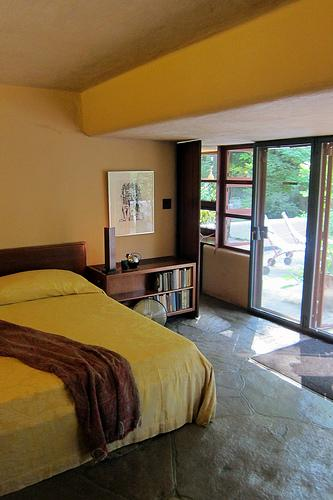

Generated Caption for /kaggle/input/abcabc/test/test/test_3.jpg ------>>>  <start> a large bed is in a room with a lot of pillows on it there is a white toilet in the corner of the room there are two white curtains on the wall behind the bed


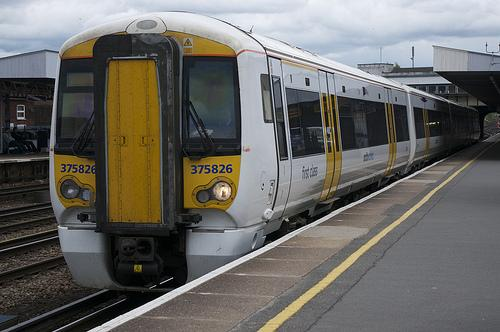

Generated Caption for /kaggle/input/abcabc/test/test/test_11.jpg ------>>>  <start> a train is on the tracks the train is white and blue there is a red light on the train the train is yellow and blue there are lights on the train the train tracks are made of metal the train is yellow and blue there


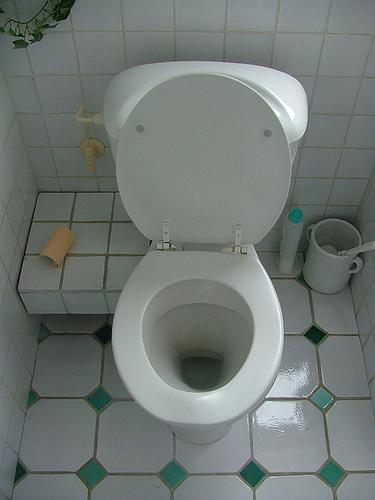

Generated Caption for /kaggle/input/abcabc/test/test/test_77.jpg ------>>>  <start> a toilet is in the bathroom the toilet is white and the lid is a white color the lid on the toilet is white the lid on the toilet is white the lid on the toilet is white the lid on the toilet is white the


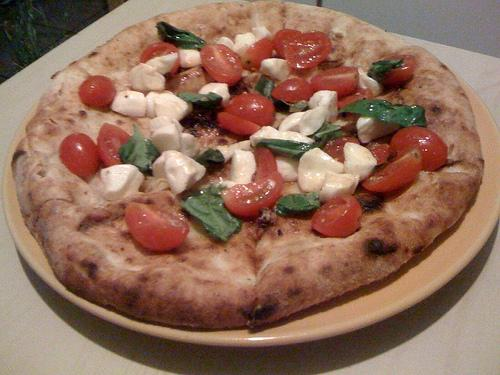

Generated Caption for /kaggle/input/abcabc/test/test/test_379.jpg ------>>>  <start> a plate is full of food the food is on a white plate the plate is sitting on top of a white plate there is a fork on the plate there is a fork on the plate


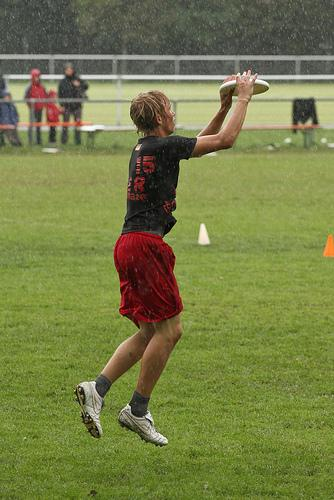

Generated Caption for /kaggle/input/abcabc/test/test/test_43.jpg ------>>>  <start> a man in a white shirt and blue shorts is standing on a baseball field he is wearing a white uniform with a white stripe down the side there is a white ball behind the man


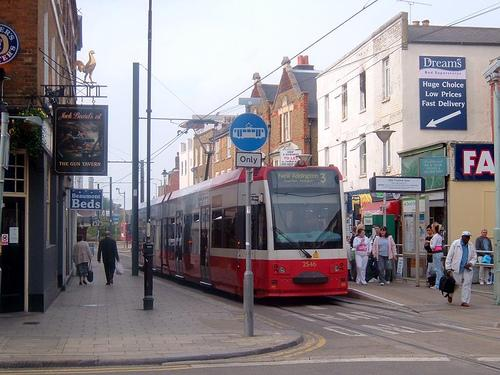

Generated Caption for /kaggle/input/abcabc/test/test/test_47.jpg ------>>>  <start> a bus is driving down the street the bus is red and has a red stripe down the side the bus is red and has a white stripe down the side the bus is parked on the street the street has many windows the bus is


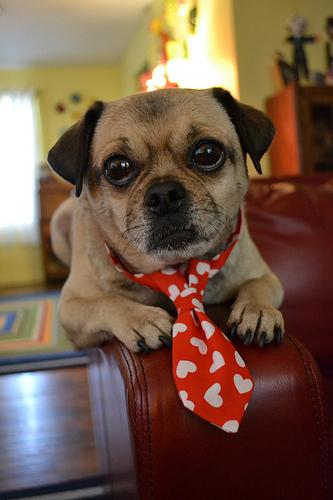

Generated Caption for /kaggle/input/abcabc/test/test/test_100.jpg ------>>>  <start> a cat is sitting on a bed the cat is black and white the cat has a black nose the cat has a black nose the cat has a black nose the cat has a black nose the cat has a black nose the cat has


In [79]:
# Testing captions for some images 
from IPython.display import display
my_test_images = ['/kaggle/input/abcabc/test/test/test_3.jpg','/kaggle/input/abcabc/test/test/test_11.jpg','/kaggle/input/abcabc/test/test/test_77.jpg','/kaggle/input/abcabc/test/test/test_379.jpg','/kaggle/input/abcabc/test/test/test_43.jpg','/kaggle/input/abcabc/test/test/test_47.jpg','/kaggle/input/abcabc/test/test/test_100.jpg']
for x in my_test_images:
    image = Image.open(x)
    display(image)
    caption = generate_caption(x, cnn_encoder, decoder, image_transforms, word_to_idx, idx_to_word)
    print(f"Generated Caption for {x} ------>>>  {caption}")

**Outputs**
Kaggle console was repeatedly crashing so we first in a JSON file and share below our results

In [3]:
{
    "test_1.jpg": "<start> a city street with many cars parked on it a bus is driving down the street there are two large buildings in the background and a green sign with a red stripe down the side the bus is red and white with a red stripe down",
    "test_2.jpg": "<start> a person is standing on a beach the man is wearing a black jacket and black pants the man is wearing a black jacket and black pants the man is wearing a black jacket and black pants the man is wearing a black jacket and black",
    "test_3.jpg": "<start> a bed is sitting in a room there is a white door in the room there are two white chairs behind the bed there is a white rug on the wall",
    "test_4.jpg": "<start> a train is on the tracks there are two large windows on the train the train is yellow and yellow there are many windows on the train the train is yellow and yellow there are many windows on the platform the train is yellow and yellow",
    "test_5.jpg": "<start> a bus is parked at the station there are two white lights on the street in front of the bus there are two people walking on the sidewalk there are cars parked on the street there are many windows on the street",
    "test_6.jpg": "<start> a large brown bear is standing on a grassy field the grass is green and green in color there are two people standing in front of the building",
    "test_7.jpg": "<start> a man is standing in the middle of a room of a home the man is wearing a black shirt and black pants the man is wearing a black shirt and a black tie he is holding his arm up with his hands in his hand",
    "test_8.jpg": "<start> a group of people are walking on a road there are people standing in front of the buildings there are people standing in front of the buildings there are people standing in front of the buildings there are people standing in front of the buildings there",
    "test_9.jpg": "<start> a white refrigerator is sitting in a room there are two white chairs behind the laptop",
    "test_10.jpg": "<start> a cat is sitting on a bed the chair is white the cat has black eyes the cat is laying on a bed there are two cats on the bench the bear is wearing a black jacket the man is wearing a black jacket the man",
    "test_11.jpg": "<start> a train is on the tracks the train is yellow and red the train is on the train tracks the train is yellow and white the train is on the train tracks there are wires above the train there is a train on the tracks the",
    "test_12.jpg": "<start> a woman is standing in front of a large tree the horse is brown and has a white face and its head is up in the air she is wearing a black jacket and black pants the woman is wearing a black jacket and a black",
    "test_13.jpg": "<start> a plate of food sits on top of a table there are two slices of pizza on a table the table is made of wood there are some pieces of broccoli and some white plates",
    "test_14.jpg": "<start> a dog is standing on the edge of a rock the bear is looking to the left the dog is looking to the left the dog is looking to the left the bear is looking to the left the bear is looking to the left the",
    "test_15.jpg": "<start> a man is walking on the beach he is wearing a black jacket and black pants he is holding a white frisbee in his hand there is a large tree behind the man",
    "test_16.jpg": "<start> a large white building with a lot of windows there is a large tree in front of the building there are many trees in the background",
    "test_17.jpg": "<start> a bathroom with a white toilet in it there is a white toilet in the bathroom the bathroom has a white toilet in it there is a white toilet in the bathroom the wall behind the toilet is white the toilet is white the toilet is",
    "test_18.jpg": "<start> a person is standing on top of a surfboard the surfboard is white the water is calm the water is calm the water is calm and murky there are small waves in the water the water is calm and murky",
    "test_19.jpg": "<start> a white plate is sitting on a table there is a white plate on the table there is a fork on the table",
    "test_20.jpg": "<start> a large white and blue vase sits on a bench in front of a large white building there are two large windows in the background with a white stripe down the side the man is standing on the ground in front of the bench there is",
    "test_21.jpg": "<start> a large white boat with a blue sky and blue and white stripes are flying in the air there are trees in the distance behind the water there are trees in the distance behind the water there are trees in the distance behind the water there",
    "test_22.jpg": "<start> a large white airplane with a large propeller on top of it the sky is blue with white clouds in it there are two large white clouds in the sky above the planes there are two large white clouds in the sky above the planes there",
    "test_23.jpg": "<start> a man is standing in a room he is wearing a white shirt and a black tie he is holding a cell phone the phone is black and the other is white the man is wearing a black shirt and a black tie the man has",
    "test_24.jpg": "<start> a man in a black shirt and white shorts is standing on a grassy field he is wearing a black and white uniform he is standing on a grassy field he is wearing a black and white striped shirt and a black and white striped frisbee",
    "test_25.jpg": "<start> a man is playing tennis on a tennis court he is wearing a white shirt and blue shorts he is standing on the tennis court in the air towards him the man is wearing a white shirt and blue shorts he is standing on the court",
    "test_26.jpg": "<start> a white plate is sitting on a table there are small flowers in the vase there is a white bowl in the middle of the water",
    "test_27.jpg": "<start> a large white boat is in the water there are people standing on the beach there are mountains in the distance behind the water there are people standing in the water there are many waves in the water",
    "test_28.jpg": "<start> a white plate is sitting on a table there is a white plate on the table there is a white plate on the table",
    "test_29.jpg": "<start> a stop sign is in front of a stop sign the sign has a sign on it that says it is not at the top of the stop sign there is a sign that says stop sign with a white sign on it the sky is",
    "test_30.jpg": "<start> a man is standing on a tennis court he is wearing a white shirt and black shorts he is holding a white frisbee in his hand he is wearing a black shirt and a black hat",
    "test_31.jpg": "<start> a large white and blue bird is sitting on a runway there are many trees in the background there are many trees in the background",
    "test_32.jpg": "<start> a man in a black wet suit is standing on a beach there are people standing in the background behind the man there are trees behind the man",
    "test_33.jpg": "<start> two elephants are standing on a hill of grass the elephants are standing on a hill there are trees behind the elephants",
    "test_34.jpg": "<start> a white and blue truck is parked in the parking lot there are two people standing on the side of the bus the bus is wearing a black jacket and black pants the motorcycle has a white face and a black helmet",
    "test_35.jpg": "<start> a bathroom is shown the clock is white with black numbers there is a clock on the top of it there is a white door to the right of the clock the clock is black and the numbers are on the clock are white the numbers",
    "test_36.jpg": "<start> a group of people are sitting at a table the woman is wearing a white shirt and has a black shirt on",
    "test_37.jpg": "<start> a man is walking on a sidewalk in front of a building a man is standing in front of a building to the left of the man is a man in a blue shirt and black pants the man is wearing a black jacket and black",
    "test_38.jpg": "<start> a large brown bear is standing in the grass there are several trees behind the bear there are trees behind the bear",
    "test_39.jpg": "<start> a man in a black jacket and black pants is standing in a field there is a large tree behind the man there are trees behind the man",
    "test_40.jpg": "<start> a city street with many cars there are many trees in the background the sky is blue with white clouds in the sky above the buildings there are many trees in the background",
    "test_41.jpg": "<start> a kitchen with a white toilet in it there is a white refrigerator in front of the refrigerator there is a white door to the right of the room there are two white towels hanging from the ceiling there is a white wall behind the sink",
    "test_42.jpg": "<start> a man in a black shirt and black pants is standing in a field of water in the water the man is wearing a black jacket and black pants the man on the left is wearing a black jacket and black pants there is a man",
    "test_43.jpg": "<start> a man in a white shirt and blue shorts is standing on a baseball field he is wearing a blue shirt and white shorts he is holding a white frisbee in his hand",
    "test_44.jpg": "<start> a large white boat with a blue sky and blue clouds in the sky the sky is blue with clouds in the sky there are many trees in the distance behind the water there are trees in the distance behind the water",
    "test_45.jpg": "<start> a man is walking on the sidewalk he is wearing a black jacket and black pants he has a black helmet on his head and goggles on his head he is standing on a sunny day",
    "test_46.jpg": "<start> a large white airplane is flying through the sky the sky is blue with clouds in the sky the sky is blue with clouds",
    "test_47.jpg": "<start> a large white building with a lot of windows there are people standing in front of the building there are two people walking on the sidewalk",
    "test_48.jpg": "<start> a large white building with a red roof is in the corner of the street there are two white pillars on the side of the road the bus is red and white with a red stripe on it the bus is parked in front of a",
    "test_49.jpg": "<start> two elephants are in a field one of the elephants is wearing a black jacket and black pants the other man is wearing a black jacket and black pants the other man is wearing a black jacket and black pants the other man is wearing a",
    "test_50.jpg": "<start> a stop sign is in front of a building the sign is on a pole the sign is on a pole the sign is on a pole",
    "test_51.jpg": "<start> a bus is parked at a street there are two large windows on the side of the bus the bus is parked on the side of the bus the bus is red and white the bus on the bus is white the bus is parked on",
    "test_52.jpg": "<start> a large brown cow is standing in the grass on a sunny day the cow has a black and white striped mane with black spots on it the cow is brown and white the cow is in front of a large body of water the water",
    "test_53.jpg": "<start> a plate of food sits on top of a table there are two white plates on the table there are two plates of food on the table there is a glass of water with a white bowl on top of it there are two slices of",
    "test_54.jpg": "<start> a man in a black shirt and black pants is standing in a parking lot there are people standing in front of the building there are people standing behind the man watching him",
    "test_55.jpg": "<start> a large white bowl with a white and blue vase sits on the wall of a kitchen there are two white plates on the counter next to the counter there are two white plates on the counter next to the counter there are two people standing",
    "test_56.jpg": "<start> a plate of food sits on a table there are two slices of pizza on the table the pizza is covered in a white bowl and a white bowl",
    "test_57.jpg": "<start> a large white and black motorcycle is parked on a sidewalk there are people standing in front of the building there are people standing behind the motorcycle watching the motorcycle",
    "test_58.jpg": "<start> a person is standing on top of a surfboard the surfboard is white the water is calm and murky there are small waves in the water the water is calm and clear there are mountains in the background there are many trees in the background the",
    "test_59.jpg": "<start> a white toilet is sitting on a wooden table there is a white and blue vase on the counter there is a small wooden table in front of the box",
    "test_60.jpg": "<start> a large brown bear is standing on a rock there is a large rock wall behind the bear there is a large rock wall behind the bear there are trees behind the bear",
    "test_61.jpg": "<start> a large white bird is flying in the sky above the airplane there is a large body of water behind the bird there is a large body of water behind the bird",
    "test_62.jpg": "<start> a large white building with a clock on it is on the side of a building there are two white pillars on the side of the building the sky is blue with white clouds in it there are two large windows on the side of the",
    "test_63.jpg": "<start> a plate of food sits on top of a white plate there are two slices of pizza on top of the pizza there are also flakes of meat and a white plate with a fork and mustard on top of it there are some pieces of",
    "test_64.jpg": "<start> there are two people sitting on a shelf they are sitting on a table there are two women standing in front of the counter both men are wearing suits the women are wearing suits the women are wearing jeans and a white shirt there are two",
    "test_65.jpg": "<start> a white plate sits on a table there are two white bowls on the table the food is on a table the table is made of wood there is a white bowl on the table behind the plate the vase is made of wood there is",
    "test_66.jpg": "<start> a clock tower with a clock on it is on a metal pole the clock is black and has a white face and a white face and a clock on it the clock is white with black numbers and numbers on it",
    "test_67.jpg": "<start> a man in a black jacket and black pants is seen on a ski slope on a sunny day there are people in the snow on the mountain there are people standing on the ground there are people standing on the beach there are people standing",
    "test_68.jpg": "<start> a baseball player is standing on a baseball field he is wearing a blue and white uniform and a white uniform a catcher is squatting behind the catcher and a catcher is squatting behind the catcher and a catcher is squatting behind the catcher is a",
    "test_69.jpg": "<start> a kitchen with a white sink and a white counter top sits in a room there is a white microwave above the stove there is a white microwave above the stove there is a white microwave above the stove there is a white microwave above the",
    "test_70.jpg": "<start> a black and white dog is standing in front of a wall there is a black and white dog in the middle of the chair the dog has a black collar around its neck",
    "test_71.jpg": "<start> a man is playing tennis on a tennis court he is wearing a blue shirt and white shorts he is holding a white frisbee in his hand and is wearing a white shirt and blue shorts he is standing on the court behind him watching the",
    "test_72.jpg": "<start> a woman is standing in front of a large window the woman is wearing a white shirt and blue jeans the woman is wearing a white shirt and has a black shirt on",
    "test_73.jpg": "<start> a man in a black shirt and black pants is standing in a field of grass there is a large rock wall behind the man there is a man in a blue shirt standing in front of the elephant there is a man in a blue",
    "test_74.jpg": "<start> a kitchen with a white toilet in it there is a large mirror hanging above the sink there are two windows in the room the walls are made of wood there is a window on the wall behind the refrigerator there is a window on the",
    "test_75.jpg": "<start> a man is standing on the sidewalk next to a large black pole the man is wearing a black jacket and black pants the man is wearing a black jacket and black pants there is a man in a blue shirt standing in front of the",
    "test_76.jpg": "<start> a large white building with a clock on it is in front of a building there is a large white building behind the sign there are two white clouds in the sky above the building",
    "test_77.jpg": "<start> a toilet is sitting on a white wall there is a white toilet in the middle of the toilet there are two white towels on the wall behind the toilet there are two white towels hanging from the toilet the toilet lid is up the toilet",
    "test_78.jpg": "<start> a little girl is sitting on a bench the girl is wearing a black jacket the girl is wearing a black jacket the girl is wearing a black jacket the girl is wearing a black jacket the girl is wearing a black jacket the girl is",
    "test_79.jpg": "<start> a man is sitting in a chair the chair is black and has a white beard the man has a black beard and black hair he is wearing a white shirt and a black tie he is holding a white remote with a white chest and",
    "test_80.jpg": "<start> a large brown bear is sitting on a bench there are two large white birds next to the bear there is a pile of rocks next to the bear",
    "test_81.jpg": "<start> a man is standing on a grassy field he is wearing a black jacket and black pants he is holding a white frisbee in his hand and is wearing a black helmet and goggles the man is wearing a black helmet and goggles the man is",
    "test_82.jpg": "<start> a giraffe is in the water the water is calm and murky there are many trees in the background there is a tree with a few trees",
    "test_83.jpg": "<start> a bed is in a room the bed has a white and blue blanket on it there is a white keyboard behind the bed there is a white wall behind the bed",
    "test_84.jpg": "<start> a large white building with a large window on it there is a large building in the street there are people standing behind the sidewalk there are people standing in front of the building",
    "test_85.jpg": "<start> two giraffes are standing in a field the giraffes are brown and white the giraffes are brown and white the giraffes are brown and white the giraffes are brown and white the giraffes are brown and white the giraffes are brown and white the giraffes are",
    "test_86.jpg": "<start> a bunch of people are sitting on a wooden table they are all wearing white shirts there are many different colors on the bananas there are many different colors on the table",
    "test_87.jpg": "<start> a large white building with a clock on it there is a large building behind the plane there are trees behind the sign",
    "test_88.jpg": "<start> a bathroom with a white sink and a white sink is seen in the corner of the room there is a white sink in front of the sink there is a white sink in front of the sink",
    "test_89.jpg": "<start> a man is surfing on a surfboard he is wearing a black wet suit he is standing on top of the surfboard the surfboard is white with a black nose there are trees in the distance behind the man",
    "test_90.jpg": "<start> a man in a black wet suit is standing on top of a surfboard the surfboard is white there are trees in the distance behind the man",
    "test_91.jpg": "<start> a group of people are standing on a beach there are two people standing on the ground in front of the elephants there are many trees in the background there are many trees in the background there are many trees in the background there are many",
    "test_92.jpg": "<start> a white building is shown in the corner of the street there are many windows on the wall behind the building there is a building behind the building",
    "test_93.jpg": "<start> a black and white image is of a truck parked in a parking lot there are two large windows on the side of the truck the truck has a white stripe down the front of it the truck has a black and white logo on it",
    "test_94.jpg": "<start> a large white refrigerator is sitting in a room there are two white curtains on the wall behind the television there are two chairs in front of the couch there is a white rug on the floor",
    "test_95.jpg": "<start> a large white and blue airplane is parked on a grassy field in the distance there are trees in the background behind the fence there are trees behind the fence",
    "test_96.jpg": "<start> a large white building with a clock on the top of it there are two white pillars on the side of the train there is a large building behind the train",
    "test_97.jpg": "<start> a man in a black wet suit is standing on a beach there are people standing in the background behind the man there are trees behind the man",
    "test_98.jpg": "<start> a man is standing in the middle of a room with a lot of water in it there are two people standing in front of the building behind him there is a large white building behind the man",
    "test_99.jpg": "<start> a pizza is sitting on a white plate the pizza has pepperoni and cheese and cheese and cheese on it the pizza is covered in a white bowl and a white sauce the pizza has cheese and cheese and cheese the crust of the pizza is",
    "test_100.jpg": "<start> a cat is laying on a bed the cat is black and white the cat has a black nose the dog has a black nose the dog has a black nose the dog has a black nose the dog has a black nose the dog has",
    "test_101.jpg": "<start> a large white airplane with a large propeller on top of a body of water the sky is blue with white clouds in the sky above it there are many trees in the background behind the boat there are two large windows in the background",
    "test_102.jpg": "<start> a man is standing in a room the man is wearing a black shirt and black pants the man is wearing a black jacket and black pants the man is wearing a black jacket and black pants the man is wearing a black jacket and black",
    "test_103.jpg": "<start> a large white and white photo is sitting on a bench in front of a large building the building is made of wood and has a white line on it there are many windows in the background there are many trees in the background",
    "test_104.jpg": "<start> a man in a black wet suit is standing on a beach there are people standing in the water behind the man there are trees behind the water",
    "test_105.jpg": "<start> a large white building with a lot of windows there is a large building behind the cars there are many trees in the background",
    "test_106.jpg": "<start> a plate of food sits on a table there are two slices of pizza on a table the table is made of wood the table is made of wood the table is made of wood the table is made of wood the table is made of",
    "test_107.jpg": "<start> a man is playing tennis on a tennis court he is wearing a blue shirt and white shorts he is wearing a blue shirt and white shorts he is wearing a blue shirt and white shorts the man is wearing a white shirt and blue shorts",
    "test_108.jpg": "<start> a white plate sits on a table there are two slices of pizza on top of the pizza the crust of the pizza is covered in a white bowl and a white plate",
    "test_109.jpg": "<start> a large white building with a clock on it is in front of a building there is a large body of water behind the building there are trees behind the building",
    "test_110.jpg": "<start> a man is standing on a bench in a park he is wearing a black jacket and black pants he has a black and white hat on his head there is a large tree behind the man",
    "test_111.jpg": "<start> two men are standing in a parking lot they are wearing a red shirt and black shorts the other man is wearing a black shirt and black shorts he is wearing a black shirt and a black hat",
    "test_112.jpg": "<start> a train is on the tracks the train is yellow and white the train is parked in the middle of a bridge the train is parked in the middle of a bridge the train is parked in the middle of the train tracks the train is",
    "test_113.jpg": "<start> a large white building with a lot of windows there is a large tree in front of the building there are trees in front of the fence",
    "test_114.jpg": "<start> a baseball player is standing on a baseball field he is wearing a blue and white uniform and a black helmet he is also wearing a black helmet and gloves he is also wearing a black helmet and gloves he is wearing a black helmet and",
    "test_115.jpg": "<start> a person is skiing down a hill the hill is covered in snow the snow is white in color the person is wearing a black jacket and black pants the person is wearing a black helmet and goggles the snow is covered in snow the snow",
    "test_116.jpg": "<start> a woman is standing on a tennis court playing tennis she is wearing a white shirt and white shorts she is holding a tennis racket in her hands a green tennis ball is soaring towards her there is a woman in a blue shirt and white",
    "test_117.jpg": "<start> a baseball player is standing on the court in a field he is wearing a blue shirt and white shorts the boy is wearing a white shirt and blue shorts the other man is wearing a white shirt and blue shorts the other man is wearing",
    "test_118.jpg": "<start> a woman in a black shirt and a black shirt is sitting in a room with a lot of food on it there are two women sitting on a shelf next to the woman there is a woman standing in front of the television",
    "test_119.jpg": "<start> a group of people are standing together on a sidewalk they are all wearing white shirts the other man is wearing a black jacket and black pants the other man is wearing a black jacket and black pants the other man is wearing a black jacket",
    "test_120.jpg": "<start> a man is riding on a skateboard he is standing on a skateboard the man is wearing a black jacket and black pants he has a black helmet on his head and goggles on his head he is standing on a sunny day",
    "test_121.jpg": "<start> a man is standing on a beach he is wearing a black jacket and black pants he is holding a black and white racket in his hand he is wearing a black helmet and a black helmet he is also wearing a black helmet and goggles",
    "test_122.jpg": "<start> a large white and blue boat is parked on the ground there are many trees in the background there is a large body of water behind the water",
    "test_123.jpg": "<start> a man is sitting in a chair the man is wearing a white shirt and has a black shirt on",
    "test_124.jpg": "<start> a white and blue truck is parked in the parking lot there are two people standing on the side of the street there are two people standing on the side of the street there are many windows on the side of the building there are many",
    "test_125.jpg": "<start> a large white boat with a large body of water in the background there is a large body of water behind the water there are trees in the distance behind the trees there are trees behind the trees",
    "test_126.jpg": "<start> a large white building sits in a field of grass there is a large body of water behind the giraffe there are trees in front of the building",
    "test_127.jpg": "<start> a white bowl is sitting on a table there are two slices of pizza on a table the table is made of wood there is a white bowl of green grass in front of the bowl",
    "test_128.jpg": "<start> two people are standing on a grassy field in a field the sky is blue with white clouds in the sky the people are standing on the ground in front of them are wearing helmets the people are standing on the ground in front of a",
    "test_129.jpg": "<start> a giraffe is standing in a field there are trees in the background there are trees behind the giraffe there are trees behind the giraffe",
    "test_130.jpg": "<start> a large white building sits in a parking lot there are many different kinds of different types of people in them there are many different colors on the pole the people are standing on top of a building",
    "test_131.jpg": "<start> a man is riding on a beach he is wearing a black jacket and black pants he is standing on top of a surfboard he is wearing a black helmet and goggles the man is wearing a black helmet and goggles the man is wearing a",
    "test_132.jpg": "<start> a man is standing on a sidewalk in front of a building a man is sitting on the ground in front of a building the man is wearing a black shirt and a black hat he is holding a black umbrella the umbrella is a light",
    "test_133.jpg": "<start> a white and blue cat is sitting on a bed there is a small white box on the ground there are two white chairs behind the bed there are two white chairs behind the bed there are two white chairs behind the bed there are two",
    "test_134.jpg": "<start> a cat is laying on a bed the cat is black and white the cat has a black nose the cat has a black nose the cat has a black nose the cat has a black nose the cat has a black nose the cat has",
    "test_135.jpg": "<start> a black and white dog is standing in a field the bear is laying on a brown wooden board the dog has a black and white striped collar around its neck the bear is looking directly at the camera the bear has a black nose and",
    "test_136.jpg": "<start> a large white building with a large backing in a parking lot sits on the sidewalk there is a large white building behind the truck there are people standing behind the truck there are people standing behind the truck",
    "test_137.jpg": "<start> a woman is sitting at a table the woman is wearing a white shirt the woman is wearing a black shirt the woman is wearing a black shirt the woman is wearing a black shirt the woman is wearing a black shirt the woman is wearing",
    "test_138.jpg": "<start> a bunch of fruit is on a table there are bananas on the plate the apples are all white and have a bunch of bananas",
    "test_139.jpg": "<start> a man in a white shirt and blue shorts is standing on a grassy field he is wearing a white shirt and blue shorts he is standing on the ground in front of him there are trees behind the people",
    "test_140.jpg": "<start> a kitchen with a white sink and a white oven sits in a room there are two windows in the room there are two windows in the kitchen there are two windows in the room there are two windows in the kitchen there are two windows",
    "test_141.jpg": "<start> a man is standing on a tennis court he is wearing a white shirt and black shorts he is holding a white frisbee in his hand he is wearing a white shirt and blue shorts the man is holding a white frisbee in his hand",
    "test_142.jpg": "<start> two people are standing on a hill in front of a large elephant the elephants are wearing black and white shirts the men are wearing hats there are people standing behind them",
    "test_143.jpg": "<start> the image is of a bathroom with a white toilet in it the walls are painted white the walls in the room are white the walls are made of wood the floor is made of wood the floor is made of wood the floor is made",
    "test_144.jpg": "<start> a pizza is sitting on a table the table is made of wood the table is made of wood the table is made of wood the table is made of wood the table is made of wood the table is made of wood the table is",
    "test_145.jpg": "<start> a plate of food sits on a table there are two slices of pizza on the table the plates are all white with a white sauce and cheese on it the plates are all white with a white and red ribbon the hot dog is on",
    "test_146.jpg": "<start> a man is playing tennis on a tennis court he is wearing a white shirt and blue shorts he is standing on the court in front of him he is wearing a white shirt and blue shorts he is standing on the court behind him are",
    "test_147.jpg": "<start> a large white bird is sitting on a runway there are many trees in the background there are many trees in the background",
    "test_148.jpg": "<start> a stop sign is in front of a building the sign is on a pole the sign is on a pole with a sign on it there are two white pillars on the side of the building there are trees behind the sign",
    "test_149.jpg": "<start> two elephants are standing in a zoo enclosure one of them is looking towards the camera and has a long neck the adult elephant is looking at the camera the elephants are standing on a rock wall behind the elephant is a large rock wall with",
    "test_150.jpg": "<start> a cat is sitting on a bed the bed is brown and white the cat has a black nose the cat has a black nose the cat has a black nose there is a black bag on the floor next to the cat",
    "test_151.jpg": "<start> a woman in a black shirt and black pants is sitting in a room with a white door on it there are two women standing behind the woman there are two women standing behind the woman in the room there are two women standing behind the",
    "test_152.jpg": "<start> a large white building with a lot of windows there is a large building behind the bus there are people standing on the street next to the street",
    "test_153.jpg": "<start> a man is standing on a grassy field he is wearing a black shirt and black shorts he is standing on a green grassy field he is wearing a black and white shirt and black shorts and a black helmet the man is wearing a black",
    "test_154.jpg": "<start> a tall brick building with a clock on it is seen in a large white building the building has a clock on it the clock is white with black numbers there are many windows on the building",
    "test_155.jpg": "<start> there are two plates of food on the table the plates are made of wood there are some pieces of food on the table there are two plates of food on the table the plates are sitting on a table there are two white plates on",
    "test_156.jpg": "<start> a woman is sitting at a table the woman is wearing a white shirt and has a black shirt on",
    "test_157.jpg": "<start> a zebra is standing in front of a fence the zebra is standing on a dirt field there are trees behind the zebra",
    "test_158.jpg": "<start> a man is standing on a tennis court playing tennis he is wearing a blue shirt and black shorts he is standing on the court in front of him he is wearing a white shirt and blue shorts and is standing on the ground behind him",
    "test_159.jpg": "<start> a large white and red bus is parked on the street there are people standing on the side of the street there is a man in a blue shirt standing on the side of the road",
    "test_160.jpg": "<start> a white desk is against a wall there is a white keyboard in front of the computer there is a television on a stand next to the bed",
    "test_161.jpg": "<start> a white table has a large white bowl on top of it there is a white and black box on the ground there are two white plates on the table",
    "test_162.jpg": "<start> two giraffes are standing in a field the grass is green and green the giraffes are standing on a tree the giraffes are brown and white the giraffes are standing on a tree the giraffes are brown and white the giraffes have long necks they are",
    "test_163.jpg": "<start> a clock is on the top of a clock the clock is black and has a white face and roman numerals the clock is white with black numbers there is a clock on the top of the clock the clock is also white in color there",
    "test_164.jpg": "<start> a man is standing on the ground in a field the man is wearing a black jacket and black pants the man is wearing a black jacket and black pants the man is wearing a black jacket and black pants the man is wearing a black",
    "test_165.jpg": "<start> a man is standing on a grassy field he is wearing a black shirt and a black hat he is holding a white frisbee in his hand there is a man in a blue shirt standing in front of him",
    "test_166.jpg": "<start> a group of people are walking on a sidewalk they are all wearing helmets there are people standing in the background there are people standing in front of the building",
    "test_167.jpg": "<start> a plane is flying in the sky the plane is white with a blue tail on it is parked in front of the plane there are small clouds in the sky above the plane",
    "test_168.jpg": "<start> a building is in the middle of the building the clock is black and has a white face and a white face the sign on the clock is black and the numbers on the clock are black in color",
    "test_169.jpg": "<start> a tall brick building with a lot of windows there is a large building in the background there is a tall building in the background",
    "test_170.jpg": "<start> a train is parked on a train track the train is red and white the train has a lot of windows there is a car parked on the road the train is red yellow and white the train has a lot of windows there is a",
    "test_171.jpg": "<start> a polar bear is standing on a rock the bear is looking at the camera the bear is looking to the left the bear is looking at the camera the bear is looking to the left the bear is looking at the camera the bear is",
    "test_172.jpg": "<start> a man is standing on a beach he is wearing a black jacket and black pants he has on a black hat and a black hat he is holding a white frisbee in his hand and is holding a white frisbee in his hand",
    "test_173.jpg": "<start> a group of people are walking on a sidewalk there are many people in the background there are people standing in front of the building there are many people standing in front of the building there are many people standing in front of the building there",
    "test_174.jpg": "<start> a white plate sits on a table there are two white plates on the table behind the table",
    "test_175.jpg": "<start> a bunch of people are gathered around a large wooden table they are all wearing white shirts the people are holding umbrellas and they are all wearing blue and white there are many people in the background",
    "test_176.jpg": "<start> a woman is sitting at a table the woman is wearing a white shirt the woman is wearing a white shirt the woman in the middle is wearing a white shirt the woman in the middle is wearing a white shirt the woman in the middle",
    "test_177.jpg": "<start> a large white building with a clock on it there is a white building behind the building there are two white pillars on the side of the building there is a building behind the building",
    "test_178.jpg": "<start> two people are standing in a parking lot they are wearing white shirts they are wearing black shirts and white pants they are wearing black shirts and white pants they are all wearing shirts and pants they are standing on a hill of grass there are",
    "test_179.jpg": "<start> a man is sitting in a chair the dog is wearing a white shirt the man is wearing a black shirt and a black hat the man has a beard on his face the man is wearing a black shirt and a black hat",
    "test_180.jpg": "<start> a bunch of people are gathered in a field the sky is blue with clouds in the sky the sky is blue with clouds",
    "test_181.jpg": "<start> a man is sitting on a bench in front of a building the man is wearing a black shirt and black pants the man is wearing a black shirt and a black tie he is holding a cell phone the man is wearing a black shirt",
    "test_182.jpg": "<start> a large brown bear is standing in front of a building there is a large rock wall behind the bench there is a large tree behind the fence",
    "test_183.jpg": "<start> a white toilet is sitting in a room there is a white toilet in front of the toilet there is a white wall behind the bed",
    "test_184.jpg": "<start> a kitchen with a white sink and a white oven sits in a room there are two white towels hanging on the wall above the counter there is a shelf on the wall behind the counter",
    "test_185.jpg": "<start> a bus is parked at the intersection there are two people walking on the sidewalk the bus is wearing a red helmet there is a red sign on the side of the bus",
    "test_186.jpg": "<start> a large white building with a lot of arches on it the giraffe is standing in front of a large tree the tree is brown and has green leaves on it there are many trees in the background",
    "test_187.jpg": "<start> a large white building with many windows on it there are many trees in the background there is a building behind the building",
    "test_188.jpg": "<start> a man is playing tennis on a tennis court he is wearing a white shirt and black shorts he is holding a white frisbee in his hand he is wearing a white shirt and blue shorts he is standing on the court behind him is a",
    "test_189.jpg": "<start> a large black and white cow is standing in the water there are two people standing in the water behind the elephant there is a large white cow behind the elephant there are people standing in front of the elephant",
    "test_190.jpg": "<start> a train is on the tracks there are many windows on the side of the train the train tracks are made of metal the train is red and white the train is on a train track the train is yellow and white the train is on",
    "test_191.jpg": "<start> a little girl is sitting on a chair the chair is white and has a white beard the girl is wearing a white shirt and has a black shirt on",
    "test_192.jpg": "<start> a kitchen with a white sink and a white oven sits in a room there are two windows in the room there are two white sinks on the wall there are two windows in the room there are two chairs in front of the counter",
    "test_193.jpg": "<start> a man is standing on a beach he is wearing a black helmet and goggles the man is wearing a black helmet and goggles the man is wearing a black helmet and goggles the man is wearing a black helmet and goggles the man is wearing",
    "test_194.jpg": "<start> a bathroom with a white sink and a white sink is seen in the corner of the room there are two white sinks on the wall there are two windows in the room there are two white sinks on the wall there are two windows in",
    "test_195.jpg": "<start> a large white and red bus is parked on a sidewalk there are people standing in front of the building there are people standing behind the motorcycles there are cars parked on the side of the road there are cars parked on the street there are",
    "test_196.jpg": "<start> a large white building with a clock on it is in front of a building there is a large white building behind the clock there are many windows in the sky there are many trees in the background",
    "test_197.jpg": "<start> a table has a large white bowl on top of it there is a white bowl on the table next to the plate there is a white bowl on the table",
    "test_198.jpg": "<start> a large body of water with many boats in the background there are many boats in the water there are many boats in the water there are many boats in the water there are many boats in the water there are many boats in the water",
    "test_199.jpg": "<start> a white counter sits on a table there are two white plates on the table there are two white plates on the counter",
    "test_200.jpg": "<start> a white toilet is sitting in a room there is a white toilet in front of the toilet there is a white toilet in front of the toilet there is a white toilet in front of the toilet there is a white toilet in front of",
    "test_201.jpg": "<start> a large white building with a clock on it is in front of a large white building there are two small windows on the wall behind the wall there are many windows in the room there are many windows in the room there are many windows",
    "test_202.jpg": "<start> two elephants are standing in a field they are standing on a hill of grass there are trees behind the elephants",
    "test_203.jpg": "<start> a stop sign is in front of a building the sign is a sign that says stop and the sign is on a pole with a sign on it the sign is on a pole with a sign on it the sign is on a pole",
    "test_204.jpg": "<start> a man is standing in a room he is wearing a white shirt and a black tie he is holding a white wii remote in his hand there is a white wall behind the man",
    "test_205.jpg": "<start> a large white teddy bear is sitting on a bench the bench is made of wood there is a small tree in front of the bear",
    "test_206.jpg": "<start> a woman is sitting at a table the woman is wearing a white shirt the woman is wearing a white shirt the woman is wearing a white shirt the woman is wearing a white shirt the woman is wearing a white shirt the woman is wearing",
    "test_207.jpg": "<start> a bathroom with a white toilet in it there is a white toilet in the middle of the room there are two white towels hanging from the wall above the sink",
    "test_208.jpg": "<start> a clock is on the top of a building the clock is black and the numbers are on the clock are white the numbers on the clock are black the numbers on the clock are black the numbers on the clock are black the numbers on",
    "test_209.jpg": "<start> two elephants are in a field the field has green grass and green leaves the cows are brown and white the cows are standing on a dirt field there are trees behind the trees",
    "test_210.jpg": "<start> a train is on the tracks there are many trees in the background the sky is blue with clouds in the sky the sky is blue with clouds",
    "test_211.jpg": "<start> a teddy bear is sitting on a chair the chair is white and the other is white the walls in the room are white the walls in the room are white the walls in the room are white the walls in the background are white the",
    "test_212.jpg": "<start> a bus is parked at the intersection there are two people walking on the sidewalk the bus is wearing a black jacket the bus has a red stripe down the side there are two people walking on the sidewalk",
    "test_213.jpg": "<start> a man in a black jacket and black pants is standing in a parking lot there are several trees in the background the sky is blue and has clouds in it",
    "test_214.jpg": "<start> a large brown bear is standing in the grass there are several trees in the background there are trees behind the fence",
    "test_215.jpg": "<start> a baseball player is standing on a baseball field he is wearing a blue and white uniform and a black helmet he is holding a white frisbee in his hand and is wearing a white baseball cap and a white uniform the player is wearing a",
    "test_216.jpg": "<start> a white toilet is in the corner of a room there is a white toilet in the middle of the bathroom there is a white toilet in the middle of the wall there is a white towel hanging from the wall behind the sink",
    "test_217.jpg": "<start> a train is on the tracks there are many windows on the train there is a car parked on the street the train is red and white there are many windows on the train there is a car parked on the street the train is red",
    "test_218.jpg": "<start> a group of people are sitting on a bench the bench is made of wood and is made of wood there is a large tree in front of the building there are many people standing in front of the building there are many people standing in",
    "test_219.jpg": "<start> a person is surfing in the water the water is calm and murky there are people in the water and the water is calm and murky there are people in the water and the water is calm and murky",
    "test_220.jpg": "<start> a large white building with a lot of windows there are many windows on the street there are people standing in front of the building",
    "test_221.jpg": "<start> a woman in a black shirt and a black suit is sitting on a chair there are two women sitting on a bench in front of the woman there are two women sitting on the floor next to them there is a man sitting on a",
    "test_222.jpg": "<start> two people are walking on a sidewalk they are all wearing helmets there is a man in a blue shirt and a black hat",
    "test_223.jpg": "<start> a man is surfing on a surfboard he is wearing a black wet suit he is standing on top of a surfboard the surfboard is white and the water is blue there are trees in the distance behind the man",
    "test_224.jpg": "<start> a large white bowl sits on a table in front of a wall there are two white bowls on the wall behind the table there are two plates of food on the table",
    "test_225.jpg": "<start> a cat is sitting on a bed the bed is made of wood the cat is sitting on a bed the bed is made of wood the cat is sitting on a bed the floor is made of wood the cat is sitting on a bed",
    "test_226.jpg": "<start> a kitchen with a white toilet in it there is a white refrigerator in the room there are two white towels hanging on the wall above the counter",
    "test_227.jpg": "<start> a plane is flying in the sky the sky is blue with white clouds in the sky the sky is blue and clear the sky is blue with white clouds",
    "test_228.jpg": "<start> a large white boat with a large body of water in the background there are many boats in the water there are many boats in the water there are many boats in the water there are many boats in the water there are many boats in",
    "test_229.jpg": "<start> a man is standing on a baseball field he is wearing a blue shirt and black shorts he is standing on top of a white frisbee the man is wearing a black helmet and black and white shorts the man is wearing a black helmet and",
    "test_230.jpg": "<start> a black and white cat is sitting on a bed with white curtains on it there is a white blanket on top of the bed behind the man",
    "test_231.jpg": "<start> two elephants are standing on a beach one of them is wearing a black and white striped color and the other is a brown color the water is a deep brown and brown color the cows are brown and white the cows are standing on the",
    "test_232.jpg": "<start> a woman is sitting at a table the woman is wearing a white shirt the woman is wearing a black jacket the woman is wearing a black shirt the woman is wearing a black shirt the woman is wearing a black shirt the woman is wearing",
    "test_233.jpg": "<start> a large brown bear is standing in the grass there are several trees behind the bear there are trees behind the bear",
    "test_234.jpg": "<start> two elephants are standing on a grassy field one of the cows is standing on the grass the sky is blue and clear there are many trees in the background of the field there are many trees in the background of the field there are many",
    "test_235.jpg": "<start> a large white refrigerator is sitting in a room there are two small windows in the room behind the table there are two chairs in front of the couch there are two chairs in front of the couch",
    "test_236.jpg": "<start> a group of people are standing on a beach there are two people standing on the ground in front of the field there are trees behind the people",
    "test_237.jpg": "<start> a man in a black shirt and white shorts is standing on a baseball field he is wearing a black shirt and black shorts he is standing on top of a white frisbee the man on the left is wearing a black shirt and blue shorts",
    "test_238.jpg": "<start> a group of people are standing on a baseball field the field has many white lines on it there are people standing in the background behind the men the men are wearing white shirts",
    "test_239.jpg": "<start> a large white and black horse is walking in the grass there are trees behind the trees there are trees behind the trees",
    "test_240.jpg": "<start> a group of people are sitting at a table the table is white and a white color the people are sitting on the table in front of the children are two men and one man have a white umbrella the one on the left is white",
    "test_241.jpg": "<start> a train is on the train tracks there is a white pole with a sign on it there are two white pillars on the side of the train there is a building behind the train",
    "test_242.jpg": "<start> a large black bear is standing on a rock there is a large rock wall behind the bear there are trees behind the bear",
    "test_243.jpg": "<start> a bunch of people are sitting at a table there are two people sitting at a table there are two women sitting on a table there are two plates of food on the table there are bananas on top of the table there are bananas on",
    "test_244.jpg": "<start> a large brown elephant is walking in the grass in a field there are two elephants in the field there are two elephants in the field they are standing on grass",
    "test_245.jpg": "<start> a woman is sitting at a table the woman is wearing a white shirt the woman is wearing a white shirt the woman is wearing a white shirt the woman is wearing a white shirt the woman is wearing a white shirt the woman is wearing",
    "test_246.jpg": "<start> a cat is laying on a bed the cat is black and white the cat has a black nose the cat has a black nose the cat has a black nose the dog has a black nose the dog has a black nose the dog has",
    "test_247.jpg": "<start> a black and white cat is sitting on a wooden bench in front of a large brown bear the bear is wearing a black collar there is a large white bear sitting on the floor",
    "test_248.jpg": "<start> a man is skiing down a hill he is wearing a black helmet and goggles the man is wearing a black helmet and goggles the man is wearing a black helmet and goggles the man is wearing a black helmet and goggles the skier in the",
    "test_249.jpg": "<start> a man is surfing on a surfboard he is wearing a black jacket and black pants he has on a black helmet and goggles the man is wearing a black jacket and black pants he is standing on top of a white surfboard there are trees",
    "test_250.jpg": "<start> a large brown bear is standing on a rock there is a large rock wall behind the fence there is a fence behind the bear",
    "test_251.jpg": "<start> a clock tower with a clock on it is on a metal pole the clock is black and has a white face and roman numerals the clock is black and the numbers are on the clock are white and the numbers are on the clock are",
    "test_252.jpg": "<start> a white toilet is in a room there is a white and blue blanket on the bed there is a white wall behind the bed",
    "test_253.jpg": "<start> a man is walking on the beach he is wearing a black wet suit he is standing on top of a white surfboard there are trees behind the man",
    "test_254.jpg": "<start> a man in a black jacket and black pants is seen riding skis on a snowy mountain with a white surfboard on the top of it is a hill with green trees and trees in the background there are trees in the background behind the people",
    "test_255.jpg": "<start> a table has a large white plate on it there is a white bowl on the table behind the table",
    "test_256.jpg": "<start> a black and white photo is sitting on a street there is a black and white sign on the side of the bus there is a black car on the street there are people standing behind the truck there is a black car on the street",
    "test_257.jpg": "<start> a bathroom with a white toilet in it there is a white refrigerator in front of the sink there is a white microwave above the stove there is a white microwave above the stove",
    "test_258.jpg": "<start> a man is standing on the ground in a field there are many trees in the background there is a large tree behind the man",
    "test_259.jpg": "<start> a black and white photo is sitting on a street there is a black motorcycle behind the truck there are people standing on the side of the truck there is a black car parked on the side of the bus there are people standing on the",
    "test_260.jpg": "<start> a bunch of people are sitting at a table the table is made of wood the table is made of wood the table is made of wood the table is made of wood the table is made of wood the table is made of wood the",
    "test_261.jpg": "<start> a man in a black shirt and black pants is standing on a sidewalk in front of a large black car there are two people standing on the side of the street there is a man in a blue shirt standing on the side of the",
    "test_262.jpg": "<start> a city street with many signs on it there are two buses driving the street there are two buses on the side of the street there are many windows and a sign on the left side of the building there are many buildings in the background",
    "test_263.jpg": "<start> a man is surfing on a surfboard the surfboard is white the man is wearing a black wet suit the man is wearing a black wet suit",
    "test_264.jpg": "<start> a group of people are standing on a baseball field one is wearing a white shirt and blue shorts the man on the left is wearing a black shirt and black shorts he is standing on the ground in front of him the other man is",
    "test_265.jpg": "<start> a white bowl is sitting on a table there are two white bowls on the table the vase is made of wood there is a small white bowl on the table behind the plate there are two slices of pizza on the table the table is",
    "test_266.jpg": "<start> a man is standing on a beach he is wearing a black jacket and black pants he is holding a white frisbee in his hand he is wearing a black helmet and goggles",
    "test_267.jpg": "<start> a cat is sitting on a bed the bed is made of wood the cat is sitting on a bed the floor is made of wood the cat is brown and white the cat has a white collar the cat has a white collar the cat",
    "test_268.jpg": "<start> a plane is flying in the sky the plane is white with a blue tail on it is flying in the sky the plane is white and has a blue tail there are two wings on the plane",
    "test_269.jpg": "<start> a man is standing on a beach flying a kite the kite is blue and white the sky is blue and clear the sky is blue with clouds",
    "test_270.jpg": "<start> a large white building with a clock on it is in front of a building there are two white pillars on the ground there is a clock on the top of the building there are many windows in the background",
    "test_271.jpg": "<start> a man in a black shirt and white shorts is standing on a beach he is wearing a black shirt and black shorts he is standing on top of a green field of grass there is a large wave behind the man",
    "test_272.jpg": "<start> a large white building with a clock on it is in front of a building there are two large windows in the background there are many trees in front of the building",
    "test_273.jpg": "<start> a baseball player is standing on a baseball field he is wearing a blue and white uniform and a black helmet the boy is wearing a white shirt and blue shorts the man in the blue shirt is wearing a white shirt and blue shorts the",
    "test_274.jpg": "<start> a bed is sitting against a white wall there is a white keyboard in front of the computer monitor there is a white keyboard in front of the computer monitor",
    "test_275.jpg": "<start> two men are standing in a room playing with a game of tennis one of the men is wearing a white shirt and black shorts the other man is wearing a black shirt and black shorts he is wearing a white shirt and blue jeans there",
    "test_276.jpg": "<start> a large white and black dog is standing on the ground there are several people standing in front of the building there are many trees in the background",
    "test_277.jpg": "<start> a man in a black shirt and black pants is standing in a parking lot there are people standing in front of the building there are people standing behind the motorcycle",
    "test_278.jpg": "<start> a man is walking on the sidewalk in a park he is wearing a black jacket and black pants he has a black and white hat on his head there is a black fence behind the man",
    "test_279.jpg": "<start> a large white building sits in a parking lot there are several people standing in front of the building there are many trees in front of the building",
    "test_280.jpg": "<start> a large white building sits in the middle of a field of grass the ground is covered in snow and there is a small white house with a blue and white stripe down the side there is a small building behind the bird",
    "test_281.jpg": "<start> a train is on the tracks there are train tracks on the train the train is yellow and yellow there are many windows on the train the train is on the train tracks the train is yellow and yellow there are many windows on the train",
    "test_282.jpg": "<start> a man is playing tennis on a tennis court he is wearing a white shirt and blue shorts he is standing on the ground in front of him he is wearing a white shirt and blue shorts the man is wearing a black helmet and goggles",
    "test_283.jpg": "<start> a large white building with a clock on it there is a white sign with a white sign on it there are two white pillars and a white building",
    "test_284.jpg": "<start> a man is skiing down a hill he is wearing a black helmet and goggles the man is wearing a black helmet and goggles the man is wearing a black helmet and goggles the man is wearing a black helmet and goggles the man is wearing",
    "test_285.jpg": "<start> a train is on the tracks the train is yellow and white the train is on a train track the train is yellow and the sky is blue with white clouds in it the sky is blue and has a white pole the sky is partly",
    "test_286.jpg": "<start> a man is standing in front of a building the man is wearing a black shirt and black pants the man is wearing a black shirt and a black hat he is holding a black and white dog in his hand there is a large rock",
    "test_287.jpg": "<start> two people are standing in a field of grass there are two people standing in the background there are people standing in front of them",
    "test_288.jpg": "<start> a plane is flying in the sky the plane is white with black stripes on it the plane is white and has a white stripe on it the tail of the plane is white and blue and has a white stripe on it the tail of",
    "test_289.jpg": "<start> two men are standing in a room they are all wearing helmets there is a man in a blue shirt and blue jeans there are two men in front of the men and a woman can be seen standing behind the men watching the men on",
    "test_290.jpg": "<start> a person in a blue shirt and black pants is standing on top of a hill there is a person standing in the water behind him there are trees behind the water",
    "test_291.jpg": "<start> a white microwave is sitting on a wooden table there is a white rug on the floor there is a white rug on the floor",
    "test_292.jpg": "<start> a man is standing on a grassy field he is wearing a black and white striped shirt and a black hat he is holding a white frisbee in his hand and he is looking at the camera and holding a white frisbee there is a white",
    "test_293.jpg": "<start> a black and white cat is sitting on a bed with a white comforter on it the cat is sitting on a wooden bench in front of the couch there is a black and white dog sitting on the floor there is a black and white",
    "test_294.jpg": "<start> two elephants are in a field the elephants are standing on a hill there is a large tree behind the elephants there are trees behind the elephants",
    "test_295.jpg": "<start> two men are standing on a road outside on a sunny day the men are wearing hats and are standing on the side of the road a man is standing on the side of the road a man is standing on the side of the road",
    "test_296.jpg": "<start> there are two white plates on the table there are two plates of food on the table there are two plates of food on the table there are two plates of food on the table there are two plates of food on the table there are",
    "test_297.jpg": "<start> a plate of food sits on a table there are two plates of food on the table the table is made of wood there is a white bowl of food on the table next to the plate there is a bowl of food on the table",
    "test_298.jpg": "<start> a large white building with a lot of windows there is a man in a blue shirt standing in front of a building there is a large tree behind the fence",
    "test_299.jpg": "<start> a man is standing on the sidewalk he is wearing a black jacket and black pants he is holding a black and white umbrella he is standing on the ground the man is wearing a black jacket and black pants he is wearing a black jacket",
    "test_300.jpg": "<start> a plane is flying in the sky the plane is white with a blue tail on it the tail is flying in the air the sky is blue with clouds",
    "test_301.jpg": "<start> a bed is in a room with a white painted design on it there is a white and black cat sitting on the floor there is a white rug on the floor",
    "test_302.jpg": "<start> a woman in a black shirt and white shorts is standing on a grassy field she is wearing a black and white striped shirt and black shorts and a black and white striped frisbee in the middle of the field the grass is green and green",
    "test_303.jpg": "<start> a little girl is sitting on a chair the teddy bear is brown with a white chest and a black hat the man is wearing a black shirt and a black tie he is holding the pizza he has a white beard",
    "test_304.jpg": "<start> a man is standing on a sidewalk in front of a large body of water the man is wearing a black jacket and black pants he is holding a black and white umbrella in his hand there are two people standing behind him",
    "test_305.jpg": "<start> a large white boat with a blue sky and blue clouds in the sky the sky is blue with clouds in the sky there are many trees in the background",
    "test_306.jpg": "<start> a man is sitting at a table the man is wearing a white shirt the man is wearing a white shirt there are people sitting in the picture there is a man in a blue shirt behind the girl",
    "test_307.jpg": "<start> a large white and blue sky is parked in the grass there are several trees in the background there are trees behind the fence",
    "test_308.jpg": "<start> a black motorcycle is parked on the street there is a man in a blue shirt standing on the side of the bus there is a car parked behind the bus",
    "test_309.jpg": "<start> a man in a black wet suit is standing on top of a hill the surfboard is white and has a white stripe down the side the man is standing on the beach there are mountains in the distance behind the man",
    "test_310.jpg": "<start> a large brown bear is standing in front of a large rock wall there are two large white birds on the ground in front of the elephant there is a large rock wall behind the bear",
    "test_311.jpg": "<start> a large white building with a lot of windows there is a large tree in front of the building there are many trees in front of the building",
    "test_312.jpg": "<start> a table has a large white plate on it there is a cake with food on it there are two glasses and a spoon on the table",
    "test_313.jpg": "<start> two people are walking on a sidewalk they are all wearing helmets and hats they are standing on a sidewalk in front of a building there are people standing behind them",
    "test_314.jpg": "<start> a man is riding a motorcycle the motorcycle is parked on a paved road the man is wearing a black jacket and black pants the man is wearing a black jacket and black pants he is also wearing a black jacket and a black helmet",
    "test_315.jpg": "<start> a person is walking on a beach the person is wearing a black jacket and black pants the person is wearing a black jacket and black pants the person is wearing a black jacket and black pants the person is wearing a black jacket and black",
    "test_316.jpg": "<start> a man in a black shirt and black pants is standing in a parking lot there are people standing in front of the building there are people standing behind the man",
    "test_317.jpg": "<start> a large white building with a lot of windows there is a man in a blue shirt standing in front of the building there are many trees in front of the building",
    "test_318.jpg": "<start> a living room is a hotel room with a white door and a white door a white and black desk is hanging from the wall a small brown couch is sitting against a wall a white refrigerator is sitting against a wall there is a white",
    "test_319.jpg": "<start> a large brown cow is standing in front of a large brown horse the horse is brown and has a black mane the zebra has a black and white mane the zebra has a black nose and a black nose there are two brown horses in",
    "test_320.jpg": "<start> a large white building with a clock on it is on the side of a building there are two white pillars on the side of the building there are many windows on the side of the building there are many windows on the building",
    "test_321.jpg": "<start> a large brown bear is standing on top of a rock wall the zebra is standing on a rock wall behind the giraffe is a large rock wall behind the giraffe is a large tree with a few patches of grass the zebras are standing on",
    "test_322.jpg": "<start> two zebras are standing in a field of grass the grass is green and white the zebra on the left is standing on a dirt field there are trees behind the zebras",
    "test_323.jpg": "<start> a cat is sitting on a bed the chair is white and has a white comforter the cat is sitting on a wooden bench there is a small brown bear sitting on the floor",
    "test_324.jpg": "<start> a train is on the tracks there are many windows on the train the train is yellow and yellow there are many lights on the train tracks the train is yellow and red there are cars parked on the platform the train is yellow and white",
    "test_325.jpg": "<start> a cat is sitting on a bench the bench is made of wood the bear is brown and has a white face the bear is looking at the camera the bear is wearing a black collar the dog is looking to the left the bear is",
    "test_326.jpg": "<start> a woman is sitting at a table the woman is wearing a white dress and a white dress the cake is sitting on a table the table is made of wood the table is made of wood the table is made of wood the table is",
    "test_327.jpg": "<start> a woman is sitting at a table in a restaurant the woman is wearing a white shirt and has a black shirt on",
    "test_328.jpg": "<start> a large white and brown dog stands in a field of grass the grass is green and green there are many trees in the background",
    "test_329.jpg": "<start> a bathroom is shown with a white toilet there are two white towels hanging from the top of the toilet there is a white toilet in the middle of the bathroom",
    "test_330.jpg": "<start> a man is standing on the sidewalk he is wearing a black jacket and black pants he is holding a black and white racket in his hand he is wearing a black helmet and goggles the shirt to the left of him is a black and",
    "test_331.jpg": "<start> a large brown bear is standing on a rock the bear is looking at the camera the bear has a black nose and black and white stripes the bear has a black nose and black and white stripes the bear has a black nose and black",
    "test_332.jpg": "<start> a large brown horse is standing in front of a fence there are trees behind the fence there are trees behind the fence",
    "test_333.jpg": "<start> a woman is standing in front of a building she is wearing a white shirt and black shorts she is holding a white frisbee in her hand and wearing a white shirt and blue jeans there are two people standing behind them behind the woman",
    "test_334.jpg": "<start> a man is sitting at a table in a room he is wearing a black shirt and a black tie he is sitting on a chair there are two women sitting on the floor next to him there is a man sitting in front of the",
    "test_335.jpg": "<start> a bunch of people are gathered around a large white building there are many trees in the background there are many trees in the background",
    "test_336.jpg": "<start> a train is on the tracks there are many trees in the background the sky is blue with white clouds in the sky the sky is blue with white clouds in the sky the sky is blue with white clouds in the sky the sky is",
    "test_337.jpg": "<start> the image is of a kitchen the kitchen is clean and white the walls are made of wood the cabinets are white the walls are made of wood the cabinets are white the walls are made of wood there are two white towels hanging from the",
    "test_338.jpg": "<start> a man is standing on a beach he is wearing a black jacket and black pants he is wearing a black jacket and black pants he is wearing a black jacket and black pants he is wearing a black jacket and black pants there is a",
    "test_339.jpg": "<start> a plane is flying in the sky the plane is white with a blue tail on it the plane has a white stripe and a blue tail there are trees behind the plane",
    "test_340.jpg": "<start> a cat is laying on a white blanket the cat has a black nose and black and white stripes the eyes are black and white the cat has a black nose the dog has a black nose and ears the eyes of the bird are black",
    "test_341.jpg": "<start> a large white boat with a large amount of water in it there are many boats in the water there are many boats in the water there are many boats in the water there are many boats in the water there are many boats in the",
    "test_342.jpg": "<start> two elephants are standing together in a field they are standing on a dirt field behind the elephants are tall trees and bushes",
    "test_343.jpg": "<start> a black and white cat is sitting on top of a wooden table there is a white rug on the floor there is a small wooden table in front of the couch there is a white rug on the floor",
    "test_344.jpg": "<start> a woman in a black shirt and black pants is standing in front of a building there are two people standing behind them in front of the woman there is a woman standing in front of her",
    "test_345.jpg": "<start> a white plate is sitting on a table there is a white plate on the table there is a white plate on the table there is a white plate on the table",
    "test_346.jpg": "<start> a white toilet is sitting in a room there are two white curtains on the wall behind the banana there are two small duckling sitting on top of the table the chairs around the table is made of wood there is a small wooden table in",
    "test_347.jpg": "<start> a man is standing on the sidewalk in front of a large body of water the man is wearing a black jacket and black pants he is holding a stick in his hand and holding a white frisbee in his hand he is wearing a black",
    "test_348.jpg": "<start> a man is standing on the sidewalk in front of a large body of water the man is wearing a black shirt and black pants he is holding a stick in his hand and holding a tennis racket in his hand the court is covered in",
    "test_349.jpg": "<start> there are two people standing on the ground there are people standing in front of the building there are people standing in front of the building there are people standing in front of the building there are people standing in front of the building there are",
    "test_350.jpg": "<start> a large black and white dog is standing on the ground the ground is covered in snow the ground is covered in snow the ground is covered in snow the ground is covered in snow the ground is covered in snow the ground is covered in",
    "test_351.jpg": "<start> a man is sitting on a bench in front of a building the boy is wearing a black shirt and a black hat the man is wearing a black shirt and a black hat he is holding a white teddy bear in front of him there",
    "test_352.jpg": "<start> a train is on the tracks there are two trains on the train tracks there are many windows in the ceiling there is a large building behind the train there are many windows on the platform the train is a big color there is a train",
    "test_353.jpg": "<start> two zebras are standing in a field of grass the grass is green and brown and have their heads down the zebras are all black and white the zebras are standing on a hill",
    "test_354.jpg": "<start> a clock tower with a clock on it the clock is on the clock the clock is on the left side of the tower the clock is black and has white writing on it the clock is black and has white writing on it the sky",
    "test_355.jpg": "<start> a man is standing on a beach he is wearing a black helmet and goggles he is standing on a green grassy field he is wearing a black jacket and black pants the man is wearing a black helmet and goggles and is standing on the",
    "test_356.jpg": "<start> a bunch of fruit are on a table the table is made of wood the table is made of wood the table is made of wood the table is made of wood the table is made of wood the table is made of wood the table",
    "test_357.jpg": "<start> a man is standing on a beach he is wearing a black jacket and black pants he is standing on top of a white surfboard there is a person standing behind him there are trees behind the man",
    "test_358.jpg": "<start> a white bowl is sitting on a table there are two slices of pizza on top of the pizza the crust of the pizza is covered in a white bowl the plate and has a white bowl on it",
    "test_359.jpg": "<start> a stop sign is on the top of the train the train is painted red and white the sky is blue with white clouds in it there are many windows on the side of the train there are trees behind the train",
    "test_360.jpg": "<start> a large white building with a clock on it is on the side of a building there are many trees in the background there is a large building behind the sign",
    "test_361.jpg": "<start> a white plate is sitting on a table there is a white plate on the table there is a white bowl sitting on top of the table there is a white plate on the table",
    "test_362.jpg": "<start> a polar bear is standing in a field the bear is looking at the camera the bear is wearing a black collar the bear is standing in a large rock the bear is looking at the camera the bear is looking to the left the bear",
    "test_363.jpg": "<start> a train is on the tracks there are many windows on the side of the train the train station is a train station the train is parked on the tracks the train is yellow and white the train is on the train tracks there are wires",
    "test_364.jpg": "<start> a man is standing on a sidewalk in a park he is wearing a black shirt and a black hat he is holding a black and white umbrella in his hand there is a large building behind the man",
    "test_365.jpg": "<start> a white refrigerator is in the corner of the room there is a white sink in front of the sink there is a white microwave above the sink there are two white towels hanging on the wall above the sink",
    "test_366.jpg": "<start> two people are standing on a beach they are wearing skis and holding ski poles in their hands the other man is wearing a black jacket and black pants the other man is wearing a black jacket and black pants the man on the left is",
    "test_367.jpg": "<start> a man is standing in a room with a blue and white striped shirt on the left is a man in a blue shirt with a black shirt on and he is holding a cell phone to his ear the man is wearing a black shirt",
    "test_368.jpg": "<start> a large white building with a clock on it is in front of a building there is a clock on the top of the building there are many windows on the building",
    "test_369.jpg": "<start> a large white building sits in the middle of a field there are many windows on the side of the building there are many trees in the background there are many trees in the background",
    "test_370.jpg": "<start> a bathroom with a white toilet in it there is a white toilet in the middle of the bathroom there is a white toilet in the middle of the wall there are two windows in the room there is a white toilet in the middle of",
    "test_371.jpg": "<start> a white counter sits on top of a white counter there are two white plates on the table there are two white plates on the table",
    "test_372.jpg": "<start> a train is on the tracks there are many trees in the background the train is pulling into the station the train is yellow and white the train is on a train track the train is yellow and white the train is on a train track",
    "test_373.jpg": "<start> a pizza is sitting on a white plate the pizza has pepperoni and cheese and cheese and cheese on it the pizza is covered in powdered sugar and has a white sauce and a white sauce on it there are also flakes of meat and a",
    "test_374.jpg": "<start> a person is walking on a beach the person is wearing a black jacket and black pants the person is wearing a black jacket and black pants there are trees in the distance behind the person",
    "test_375.jpg": "<start> a group of people are standing on a beach one of the elephants is wearing a black jacket and black pants the other man is wearing a black shirt and black pants the man is wearing a black jacket and black pants the man is wearing",
    "test_376.jpg": "<start> a white bed is in a room there is a white keyboard in front of the computer monitor there is a white keyboard behind the laptop",
    "test_377.jpg": "<start> a large white boat with a blue sky and blue clouds the sky is clear and blue with a few clouds in it are in the sky the sky is blue with clouds in the sky above the sky is a clear blue sky there are",
    "test_378.jpg": "<start> a large brown bear is standing in front of a building there are several trees behind the building there are trees behind the building",
    "test_379.jpg": "<start> a plate is sitting on a table there are carrots and carrots on the plate there are carrots and carrots on the plate there are carrots and carrots on the plate there are carrots and carrots on the plate there are carrots and carrots on the",
    "test_380.jpg": "<start> a woman is standing in front of a building she is wearing a black jacket and black pants the woman is wearing a black jacket and black pants the woman is wearing a black jacket and black pants the woman is wearing a black jacket and",
    "test_381.jpg": "<start> a man is standing on a bench in front of a building the man is wearing a black jacket and black pants the man is wearing a black jacket and black pants the man is wearing a black jacket and black pants there is a man",
    "test_382.jpg": "<start> a train is on the tracks there are many trees in the background the train is red and white with a blue stripe on the front there are trees in the distance behind the train there are trees in the distance behind the train there are",
    "test_383.jpg": "<start> a man is sitting on a chair the chair is black and has a white shirt on the other side of the picture is a small wooden table with a white and blue blanket on it there are two chairs in front of the couch there",
    "test_384.jpg": "<start> a dog is laying on the ground the dog has a black collar around its neck there is a black collar around the dogs neck",
    "test_385.jpg": "<start> a man in a black shirt and black shorts is standing on a beach he is wearing a black shirt and a black hat he is holding a black and white surfboard in the air in front of him he is wearing a black and white",
    "test_386.jpg": "<start> a train is on the tracks there are many windows on the train there is a train on the tracks the train is yellow and white the train is on a train track the train is yellow and white the train is on a train track",
    "test_387.jpg": "<start> a woman is standing on a tennis court playing tennis she is wearing a white shirt and black shorts and a black skirt she is holding a tennis racket in her hands a green tennis ball is soaring towards her there is a large green tree",
    "test_388.jpg": "<start> a man is sitting on a bench in front of a building the man is wearing a black shirt and a black hat he is holding a cell phone in his hand there is a man in a blue shirt standing in front of the man",
    "test_389.jpg": "<start> a bunch of people are walking on a sidewalk there are many trees in the background there are many buildings in the background there are many trees in the background there are many trees in the background",
    "test_390.jpg": "<start> a plate of food sits on top of a white plate there are two slices of pizza on top of the pizza the crust of the pizza is covered in a white plate there are some pieces of broccoli on the plate there are some pieces",
    "test_391.jpg": "<start> a baseball player is standing on a baseball field he is wearing a blue shirt and white shorts he is standing on the grass in front of the players a catcher is squatting behind the man in the field a catcher is squatting behind the man",
    "test_392.jpg": "<start> a large white building with a lot of windows there is a large building in the background there is a large building behind the trees",
    "test_393.jpg": "<start> a white plate is sitting on a table there are small white flowers in the vase the flowers are white and some are brown there are some tweaks of broccoli the carrots are white with some white flowers",
    "test_394.jpg": "<start> a giraffe is eating hay out of a tree the giraffe is brown and has white spots on its head the tusks are black and white the giraffe has its head down and the other is brown there are trees behind the giraffe",
    "test_395.jpg": "<start> a plane is flying in the sky the plane is white and has a white stripe and a blue tail there is writing on the side of the plane",
    "test_396.jpg": "<start> a man is standing on a sidewalk in a park he is wearing a black shirt and a black hat he is holding a black and white umbrella in his hands there are two people standing behind him",
    "test_397.jpg": "<start> a person is standing on a beach there are people standing on the ground there is a person standing next to the person",
    "test_398.jpg": "<start> a large white building with a clock on it there is a white building behind the clock there are two windows in the background there is a building behind the clock",
    "test_399.jpg": "<start> a white plate sits on a table there is a piece of toast on the plate there is a fork on the table next to the plate there is a fork on the table",
    "test_400.jpg": "<start> a large brown bear is standing on a rock there is a large rock wall behind the bear there are trees behind the bear",
    "test_401.jpg": "<start> a large white building sits in a parking lot there are many trees in the background there are many trees in the background there are many trees in the background",
    "test_402.jpg": "<start> two people are standing on a beach they are standing on top of a hill the hill is white with white clouds in the background the sky is blue with clouds",
    "test_403.jpg": "<start> a bathroom is shown with a white toilet in it the toilet is white with a white shower curtain on it the shower curtain is white and the floor is a light blue color there is a small white refrigerator in front of the toilet",
    "test_404.jpg": "<start> a group of people are sitting at a table in a restaurant the table is made of wood the table is white and has a lot of bananas on it there are two people sitting at a table there are people sitting in the kitchen one",
    "test_405.jpg": "<start> a white plate sits on a table there are two slices of pizza on a table there are two slices of pizza on a table there are two slices of pizza on the table the table is made of wood there is a white bowl on",
    "test_406.jpg": "<start> a large white bowl with a white and blue vase sits on a table there are two white bowls on the wall behind the table there are two white plates on the table next to the table",
    "test_407.jpg": "<start> a train is on the tracks the train is yellow and white the train has a lot of windows the sky is blue with white clouds in the background the train is parked in front of a train the train is parked on the tracks the",
    "test_408.jpg": "<start> a bunch of people are skiing on a beach the sky is blue and clear there are many boats in the water there are many boats in the water the sky is blue and clear there are many trees in the distance there are many trees",
    "test_409.jpg": "<start> a bathroom with a white toilet in it there is a white toilet in the bathroom the wall behind the toilet is white the toilet lid is open the toilet lid is open the toilet is open and the lid to the left of the toilet",
    "test_410.jpg": "<start> a train is on the tracks the train is yellow and yellow the train is on the train tracks there are wires above the train there is a train on the tracks the train is yellow and yellow the train is on the train tracks the",
    "test_411.jpg": "<start> a man is standing on a sidewalk holding a tennis racket he is wearing a white shirt and blue jeans the man is wearing a black shirt and black shorts he is wearing a white shirt and blue jeans there is a man in a blue",
    "test_412.jpg": "<start> a large white boat is in the sky there are many boats in the water there are people standing in the background behind the boat there are many trees in the background there are many trees in the background there are many trees in the background",
    "test_413.jpg": "<start> a man is sitting on a bed with a white pillow the laptop is open the laptop is open and the other is white the walls are made of wood the table is made of wood the table is made of wood the table is made",
    "test_414.jpg": "<start> a train is on the tracks there are many trees in the background the sky is blue and has clouds in it there are many trees in the background the sky is blue and has clouds in the distance there are many trees in the background",
    "test_415.jpg": "<start> a white desk is against a wall there is a white keyboard sitting on top of the desk in front of the computer there is a white keyboard in front of the computer",
    "test_416.jpg": "<start> a giraffe stands in a zoo enclosure the giraffes are standing in front of a tree the giraffe is facing away from the camera the giraffes are standing in front of a tree the giraffe is standing in a field there are trees behind the giraffe",
    "test_417.jpg": "<start> a woman in a black shirt and black pants is standing in a room with a lot of food on it there are two women standing behind them in front of her there is a woman in a blue shirt standing in front of her",
    "test_418.jpg": "<start> a man is standing on a beach he is wearing a black helmet and goggles he is holding his racket in his hand and he is wearing a black helmet and goggles and is standing on the ground in front of him he is wearing a",
    "test_419.jpg": "<start> a large white building sits in a parking lot there are many windows in the room there are many windows in the room there are many windows in the room there are many windows in the room there are many windows in the room the walls",
    "test_420.jpg": "<start> a large white and black motorcycle is parked on a street there is a man in a blue shirt standing on the sidewalk there are people standing behind the motorcycle",
    "test_421.jpg": "<start> a man is surfing on a surfboard he is wearing a black wet suit he is standing on top of a surfboard the surfboard is white the man is wearing a black jacket and blue jeans he is standing on the surfboard the man is wearing",
    "test_422.jpg": "<start> a man is standing on a grassy field he is wearing a white shirt and blue shorts he is standing on top of a green field of grass the man is wearing a black and white uniform and a black helmet he is holding a white",
    "test_423.jpg": "<start> a dog is sitting on the ground the dog is brown and white the dog is on a wooden bench the bench is made of wood the dog is brown and white the dog is on a wooden bench the bench is made of wood there",
    "test_424.jpg": "<start> a train is on the tracks there are many windows on the train tracks the train is yellow and yellow there are many windows on the train the train is yellow and yellow there are many buildings in the background the train is pulling into the",
    "test_425.jpg": "<start> a man is sitting at a table in the kitchen the man is wearing a black shirt and a black tie he is wearing a black shirt with a blue and white striped shirt on it there is a man in a blue shirt standing in",
    "test_426.jpg": "<start> a bunch of people are gathered around a large white building there are many boats in the background there are many boats in the background there are many trees in the background",
    "test_427.jpg": "<start> a man is walking on the beach he is wearing a black jacket and black pants he is holding a white frisbee in his hand he is wearing a black helmet and goggles the man is wearing a black jacket and black pants he is holding",
    "test_428.jpg": "<start> a group of people are standing on a sidewalk in a park the woman is wearing a black jacket and black pants the woman is wearing a black jacket and black pants the woman is wearing a black jacket and black pants the woman is wearing",
    "test_429.jpg": "<start> a man in a black shirt and white shorts is standing on a grassy field he is wearing a blue shirt and white shorts he is holding a white frisbee in his hand and is wearing a black helmet and wearing a black helmet",
    "test_430.jpg": "<start> a man is standing on a grassy field he is wearing a black helmet and a black helmet he is holding a white frisbee in his hand and is wearing a black helmet and goggles the man is wearing a black helmet and goggles the man",
    "test_431.jpg": "<start> a woman is sitting at a table the woman is wearing a white shirt and holding a white frisbee there is a woman in a blue shirt standing in front of her",
    "test_432.jpg": "<start> a man is riding a motorcycle on a paved road the man is wearing a black jacket and black pants the man is wearing a black helmet and goggles on his head a black helmet and goggles are on his head there is a black car",
    "test_433.jpg": "<start> a train is parked on the tracks the train is yellow and white the train is parked on the tracks the train is yellow and white the train has a lot of windows there is a car parked on the side of the train the train",
    "test_434.jpg": "<start> a toilet is sitting on a white wall there is a white toilet in the middle of the toilet there are two white towels hanging on the wall above the toilet",
    "test_435.jpg": "<start> a large black and white cow stands in a field of grass the giraffe has a black nose and a black nose there are two large birds on the ground behind the fence",
    "test_436.jpg": "<start> a large white and blue airplane is parked on a grassy field in the background there is a large body of water behind the fence there is a large body of water behind the fence",
    "test_437.jpg": "<start> a woman in a white shirt and black pants is sitting in a room with a lot of food on it there are people standing behind them in front of the woman there are two women standing behind them in front of the women are standing",
    "test_438.jpg": "<start> a large white building with a lot of windows there is a man in a blue shirt standing in front of the building there are people standing behind the bus there are cars parked on the street next to the building",
    "test_439.jpg": "<start> a stop sign is sitting on a pole the sign is white with black letters the sky is blue with white clouds in it there are two white pillars on the side of the building the sky above the building is blue there are many windows",
    "test_440.jpg": "<start> a bed is in a room with a white painted top on it is sitting on a wooden table in front of the bed there is a white keyboard in front of the bed there is a white rug on the floor",
    "test_441.jpg": "<start> a man is standing on a baseball field he is wearing a black helmet and a black helmet he is also wearing a black helmet and goggles on his head he is wearing a black helmet and goggles and is standing on the ground in front",
    "test_442.jpg": "<start> a bathroom with a white toilet in it there is a white toilet in the middle of the bathroom there is a white toilet in the middle of the bathroom",
    "test_443.jpg": "<start> a large white building with a clock on it is on the top of a building there are two large windows on the side of the building there are two people standing on the side of the building there are many windows on the building",
    "test_444.jpg": "<start> a white toilet is sitting in a room there are two white curtains on the wall behind the banana there are two small birds on the ground next to the counter",
    "test_445.jpg": "<start> a cat is sitting on a bench the bench is made of wood the cat is sitting on a bench the bench is made of wood the bench is made of wood the bench is made of wood the bench is made of wood the bench",
    "test_446.jpg": "<start> a man is standing on the beach he is wearing a black jacket and black pants the man is wearing a black jacket and black pants he is holding a surfboard there is a man in a blue shirt standing in front of him",
    "test_447.jpg": "<start> a large brown elephant is standing in a field there are trees behind the giraffe there are trees behind the giraffe",
    "test_448.jpg": "<start> a large white boat with a large body of water in the background there are people standing in the water there are many boats in the water there are many boats in the water there are many boats in the water there are many boats in",
    "test_449.jpg": "<start> a person is walking on a beach the person is wearing a black jacket and black pants there is snow on the ground there are trees in the distance behind the person",
    "test_450.jpg": "<start> a man in a black jacket and black pants is standing in a field there are trees behind the man",
    "test_451.jpg": "<start> a city street with many different signs are shown in the city the street is very bright and rainy in the background there are many buildings in the background the building is made of concrete and there are many trees in the background",
    "test_452.jpg": "<start> a man is standing in a room in a room in a room he is wearing a white shirt and blue jeans there is a man in a blue shirt standing in front of the man there is a man in a blue shirt standing in",
    "test_453.jpg": "<start> a man is skiing down a hill he is wearing a black helmet and goggles he is standing on top of a mountain with a snowboard on it the skier is wearing a black jacket and blue jeans the man is wearing a black jacket and",
    "test_454.jpg": "<start> a large white building sits in a parking lot there are many windows in the background there are two people standing in front of the building there are many trees in the background",
    "test_455.jpg": "<start> two zebras are standing in a field of grass the zebra is standing in a field the field is surrounded by a tree the giraffe is standing in front of some grass",
    "test_456.jpg": "<start> a large white building sits in a parking lot there are two people standing in front of the bus there are two people standing in front of the building there are two people standing in front of the building there are many lights on the pole",
    "test_457.jpg": "<start> a clock tower with a clock on it is on a metal pole the clock is black and has a white face and a white face and a clock on it the clock is white with black numbers and numbers on it is visible the building",
    "test_458.jpg": "<start> a zebra is standing in front of a fence the zebra is standing on the ground the zebra is standing on a rock wall behind the zebra is a fence the giraffe is standing next to a fence",
    "test_459.jpg": "<start> a woman is sitting on a bench the woman is wearing a black jacket the woman is wearing a black jacket the woman is wearing a black jacket the woman is wearing a black jacket the woman is wearing a black jacket the woman is wearing",
    "test_460.jpg": "<start> a man is standing on a beach he is wearing a black jacket and black pants he has on a black helmet and goggles he is standing on top of a hill with trees and trees in the background there are trees behind the man",
    "test_461.jpg": "<start> a group of people are standing on a beach there are two people standing in front of the building one of the people is wearing a black jacket and blue jeans there are two people standing in the background",
    "test_462.jpg": "<start> a white toilet is sitting in a room there are two white curtains on the wall behind the bed there are two white curtains on the wall behind the bed there are two white curtains on the wall behind the bed there are two white curtains",
    "test_463.jpg": "<start> a man is walking on the sidewalk he is wearing a black jacket and black pants the man is wearing a black jacket and black pants the man is wearing a black jacket and black pants he is sitting on a bench in front of the",
    "test_464.jpg": "<start> a clock tower with a clock on it is on a metal pole the clock is very old the clock is also has a clock on it the clock has a black face and numbers on it",
    "test_465.jpg": "<start> a plate is sitting on a table there is food on top of the pizza there are carrots and mushrooms on top of the pizza there are carrots and mushrooms on top of the pizza there are carrots and mushrooms on top of the pizza there",
    "test_466.jpg": "<start> a bunch of fruit is displayed on a table the apples are in the same color white there are some white bowls on the table",
    "test_467.jpg": "<start> a man is sitting in a chair in a room he is wearing a white shirt with a black and white striped shirt on it the man is wearing a black shirt and a black hat the man is wearing a black shirt with a black",
    "test_468.jpg": "<start> a man is playing tennis on a tennis court he is wearing a blue and white uniform and a black helmet he is holding a red and white racket in his hand and a ball on the court the court is green and the sky is",
    "test_469.jpg": "<start> a man is standing in the middle of a home the man is wearing a black shirt and black shorts he is holding a white frisbee in his hand he is wearing a black shirt and a black shirt he is wearing a black shirt and",
    "test_470.jpg": "<start> a large black and white cow stands in a field of grass the cow has a black mane and a black nose the zebra has a black nose and black and white stripes the ground is covered in green grass and green leaves there are two",
    "test_471.jpg": "<start> a woman is sitting on a table the woman is wearing a white shirt the woman is wearing a white shirt the woman is wearing a white shirt the woman is wearing a white shirt the woman is wearing a white shirt the woman is wearing",
    "test_472.jpg": "<start> a large white building with a lot of windows there is a large building in the background of the building there are many trees in front of the building",
    "test_473.jpg": "<start> a large white and blue airplane is parked on a grassy field the sky is blue with clouds in the sky above the sky is blue and clear",
    "test_474.jpg": "<start> a bus is driving down the road the bus is red and the street is gray there are many buildings in the background there are many buildings in the background the street is gray there are cars parked on the side of the road the street",
    "test_475.jpg": "<start> a large brown bear is standing in the grass there is a large rock wall behind the bear there is a rock wall behind the bear",
    "test_476.jpg": "<start> two giraffes are in a field the field has green leaves and green grass and a green fence behind the giraffe there are trees behind the giraffe",
    "test_477.jpg": "<start> a train is on the tracks the train is yellow and white the train has a lot of windows the sky is blue with white clouds in the background the sky is blue and has white clouds",
    "test_478.jpg": "<start> a train is on the tracks there is a train on the tracks the train is yellow and white the train is on a train station the train is yellow and has a white line on the front there are two people standing on the platform",
    "test_479.jpg": "<start> a bunch of people are gathered around a large amount of green grass the sky is clear and blue there are many boats in the background there are many trees in the background",
    "test_480.jpg": "<start> a bathroom with a white toilet in it there is a white toilet in the bathroom there is a white toilet in the bathroom there is a white toilet in the bathroom there is a white toilet in the bathroom there is a white toilet in",
    "test_481.jpg": "<start> a large black bear is sitting on a bench in front of a building the bear is sitting on a bench the bench is made of wood there is a tree to the left of the bench the bench is made of wood there is a",
    "test_482.jpg": "<start> a man is surfing a wave he is surfing on the water he is wearing a black wet suit he is standing on top of a surfboard the surfboard is white the water is calm and murky there are mountains in the background",
    "test_483.jpg": "<start> a white bowl is sitting on a table there are two white bowls on the table the vase is made of wood there are some green leaves on the table",
    "test_484.jpg": "<start> a white table has a large white bowl on top of it there is a white bowl on the table behind the plate there are two white plates on the table",
    "test_485.jpg": "<start> a plane is parked at the airport the plane is white with a black stripe down the side of it the plane is white and has a white stripe on the front of it the plane is white and has a white stripe on the front",
    "test_486.jpg": "<start> a bathroom with a white toilet in it there is a white toilet in the middle of the room there are two white towels hanging from the wall above the sink",
    "test_487.jpg": "<start> two elephants are walking in a zoo area one elephant is looking at the camera the elephant has a long neck and a baby one elephant the elephant is wearing a black jacket and a black hat the other elephant is standing in the middle of",
    "test_488.jpg": "<start> a man in a black shirt and white shorts is standing on a beach he is wearing a black shirt and black shorts he is standing on top of a white surfboard there is a large wave behind the man the sky is blue with white",
    "test_489.jpg": "<start> a large white building sits in a parking lot there are two people standing in front of the building there are two people standing behind the cart there are two people standing behind the building there are two people standing behind the building there are two",
    "test_490.jpg": "<start> a man is sitting in a chair with a white shirt on and he is holding a sandwich on a white wii remote he is wearing a white shirt and blue jeans there is a man sitting in a chair behind him there are two people",
    "test_491.jpg": "<start> a large brown bear is sitting on a bench there are several trees in front of the building there are many trees in the background",
    "test_492.jpg": "<start> a large brown bear is standing in the water the bear is standing on a rock wall there is a large rock wall behind the bear there are trees behind the bear",
    "test_493.jpg": "<start> a man is standing on a tennis court he is wearing a white shirt and black shorts he is standing on top of a white surfboard there is a white and blue flag on the ground behind him",
    "test_494.jpg": "<start> a man in a black shirt and black pants is standing in a parking lot there are people standing behind the man there are people standing behind the man",
    "test_495.jpg": "<start> a large brown spotted giraffe is standing in a field there are trees behind the giraffe there are trees behind the giraffe",
    "test_496.jpg": "<start> a clock tower with a clock on it is in a parking lot the building is made of metal the clock is black and the numbers are on the clock are white there are two windows on the wall behind the clock the clock are black",
    "test_497.jpg": "<start> a man is standing on top of a hill he is wearing a black wet suit and holding a white surfboard in his hand he is wearing a black wet suit and holding a white surfboard in the air there is a white and blue flag",
    "test_498.jpg": "<start> a man is standing on top of a surfboard he is wearing a black wet suit and a black helmet he is standing on top of a surfboard the surfboard is white and blue there are trees behind the man",
    "test_499.jpg": "<start> a person is skiing on a snow covered hill the person is wearing a black jacket and blue pants the person is wearing a black jacket and blue shorts the person is wearing a black jacket and blue shorts the person is wearing a black jacket",
    "test_500.jpg": "<start> a man is standing on a sidewalk in a park he is wearing a black helmet and goggles he is standing on a concrete platform in front of a large green tree the trees are green and green in color the sky is blue and has",
    "test_501.jpg": "<start> a bed is sitting against a white wall there is a white rug on the floor there is a rug on the floor",
    "test_502.jpg": "<start> a white toilet is in the corner of a room there is a white sink in front of the sink there is a white sink next to the sink",
    "test_503.jpg": "<start> a man in a black jacket and black pants is standing in a field of grass there is a large rock wall behind him there is a large tree behind the man",
    "test_504.jpg": "<start> a bunch of people are gathered around a table there are many different colors on the table there are many different colors on the table there are many different colors on the table there are many different colors on the table",
    "test_505.jpg": "<start> a man is sitting on a couch in a room with a lot of pictures on it the television is hanging from the wall the man is sitting on a wooden chair in front of the television is a man in a blue shirt and a",
    "test_506.jpg": "<start> a bathroom is clean and has a white toilet in it the toilet is white and the floor is made of wood there is a small wooden table in the middle of the room there are two small windows in the room the floor is made",
    "test_507.jpg": "<start> there are two birds standing in the middle of a field the bears are black and white the bears are looking at the camera the bears are standing on a rock wall behind the bear is a large white bird the bear in the middle is",
    "test_508.jpg": "<start> a woman is sitting on a bench in front of a large building the woman is wearing a black jacket and a black hat the woman is wearing a black jacket and a black hat the woman is wearing a black jacket and a black hat",
    "test_509.jpg": "<start> a man is standing on a bench in front of a large body of water the water is very bright and blue with a few trees and leaves on it there are many trees in the background the man is wearing a black jacket and black",
    "test_510.jpg": "<start> a giraffe is standing in a field there are trees behind the giraffe there are trees behind the giraffe",
    "test_511.jpg": "<start> a man is standing on a beach he is wearing a black jacket and black pants the man is wearing a black helmet and goggles the man is wearing a black helmet and goggles the man is wearing a black helmet and goggles the man is",
    "test_512.jpg": "<start> a clock tower with a clock on it the clock is on the left side of the building the clock is black and the numbers are on the clock are white the numbers on the clock are black the numbers on the clock are black the",
    "test_513.jpg": "<start> a baseball player is standing on a field there are two people standing in front of the fence watching the game",
    "test_514.jpg": "<start> a train is on the tracks there are many windows in the background the train is yellow and has a white line on the front there are two people standing in the background the train is pulling into the station the train is on a train",
    "test_515.jpg": "<start> two people are standing on a ski slope they are all wearing skis and hats they are all wearing helmets and hats they are all wearing helmets and hats they are all wearing helmets there are people in the snow they are all wearing helmets there",
    "test_516.jpg": "<start> a bunch of people are sitting at a table there are two plates of food on the table there are two plates of food on the table there are two plates of food on the table there are two plates of food on the table there",
    "test_517.jpg": "<start> a man is standing on a beach he is wearing a black jacket and black pants he is holding a white surfboard in his hand he is wearing a black helmet and black gloves he is wearing a black helmet and black gloves he is wearing",
    "test_518.jpg": "<start> a person in a blue shirt and white pants is standing on a beach there are trees in the distance behind the person there are trees in the distance behind the person",
    "test_519.jpg": "<start> a man is standing on a sidewalk in a park he is wearing a black jacket and black pants he has a black and white hat on his head there are people standing behind him",
    "test_520.jpg": "<start> a man in a black jacket and black pants is standing in a field there are two people standing in front of the man there are people standing in front of the boat there is a man in a blue shirt standing on the ground there",
    "test_521.jpg": "<start> a man is sitting in a chair the man is wearing a white shirt and has a black shirt on",
    "test_522.jpg": "<start> a large brown bear is standing in the water the water is calm and peaceful there are many trees in the background there is a rock wall behind the bear",
    "test_523.jpg": "<start> a large white building with a clock on it is in front of a building there are two white pillars on the side of the building there are many trees in the background there is a building behind the sign there are many trees in the",
    "test_524.jpg": "<start> a man is sitting at a table the man is wearing a white shirt and has glasses on his face the man is wearing a black shirt and a black tie he is holding his arm in front of him",
    "test_525.jpg": "<start> a zebra is standing in a field there are trees behind the zebra the giraffe is standing in front of a fence the giraffe is facing away from the camera",
    "test_526.jpg": "<start> a white and blue sky is filled with trees and grass there are many trees in the background there is a large tree behind the fence",
    "test_527.jpg": "<start> a wooden desk sits against a wall there is a white rug on the floor there is a television on a stand next to the bed there is a white rug on the floor",
    "test_528.jpg": "<start> a man is sitting in a chair the man is wearing a black shirt and a black tie he is wearing a black shirt there are two people standing behind the man",
    "test_529.jpg": "<start> a large white boat with a large body of water in the background there is a large body of water behind the water there are many trees in the background",
    "test_530.jpg": "<start> a black and white photo is on a street there is a black car parked on the side of the bus there is a car parked behind the truck",
    "test_531.jpg": "<start> a black and white dog is standing in a field the bear is standing on a rock wall there is a large rock wall behind the bear there are two dogs behind the dog",
    "test_532.jpg": "<start> a group of people are standing in a field of grass there is a large body of water behind the water there are people standing in front of the fence",
    "test_533.jpg": "<start> a white couch with a white bed sits in a room there is a large window in the corner of the room there are two pillows on the wall behind the bed there are two chairs in front of the couch there is a white keyboard",
    "test_534.jpg": "<start> the image is of a bathroom with a white toilet in it the toilet is white and the bathroom is clean and has a shower curtain on it the walls are painted white there is a mirror on the wall behind the toilet there are two",
    "test_535.jpg": "<start> a large white building with a lot of windows there is a large tree in front of the fence there is a large tree in front of the fence",
    "test_536.jpg": "<start> a man is surfing on a wave the wave is very big and has a white stripe on the top of it the surfboard is white and the water is very clear",
    "test_537.jpg": "<start> a large black bear is standing on a rock there is a large rock wall behind the bear there are trees behind the bear",
    "test_538.jpg": "<start> two people are standing on a sidewalk at night one of the men is wearing a black jacket and a black hat he is wearing a black jacket and a black hat",
    "test_539.jpg": "<start> a large black dog with a black and white dog in a blue shirt is sitting in a room with a white door and a white and blue checkered bag on it the cat is sitting on a wooden bench in front of the couch there",
    "test_540.jpg": "<start> a giraffe stands in a field there are two giraffes in the background the giraffe has long hair in the background the giraffe has long hair in the background there is a large tree in front of the giraffe",
    "test_541.jpg": "<start> a bathroom with a white toilet in it there is a white toilet in the bathroom the wall in the bathroom is white the toilet is white there is a white toilet in the bathroom the wall behind the toilet is white the toilet is white",
    "test_542.jpg": "<start> two elephants are standing together on a grassy field they are standing on top of grass and they are standing on a hill of grass there are two elephants standing in the background behind them",
    "test_543.jpg": "<start> a bunch of people are gathered around a large building in the background there is a large tree with a lot of trees in the background there are many trees in the background",
    "test_544.jpg": "<start> a plane is flying in the sky the plane is white with a blue tail on it there is a white and blue airplane in the sky the sky is blue with white clouds in the sky the sky is blue with white clouds",
    "test_545.jpg": "<start> a plate of food sits on top of a white plate there are some pieces of broccoli and some sort of broccoli and some sort of meat and a fork and knife on the top of the pizza there are carrots and carrots on the plate",
    "test_546.jpg": "<start> a large bed is sitting in a room there are two chairs in front of the couch there is a white rug on the floor there is a window on the wall behind the table",
    "test_547.jpg": "<start> a man is sitting on a chair in a room with a white laptop on it there are two white towels on top of the desk there are two white lights on the walls in front of the monitors there are two chairs in front of",
    "test_548.jpg": "<start> a kitchen with a white toilet in it there is a large window in the corner of the room there are two chairs in front of the couch there is a white refrigerator behind the table",
    "test_549.jpg": "<start> a large white and white photo is sitting on a bench in front of a large white building the house is made of wood and has a white face and a white face the man is wearing a black shirt and black pants there is a",
    "test_550.jpg": "<start> a baseball player is standing on a baseball field he is wearing a blue and white uniform with a white stripe on it the player is wearing a blue and white uniform and a black helmet the catcher is wearing a red and white uniform and",
    "test_551.jpg": "<start> a bunch of people are gathered on a beach the sky is blue with white clouds in the sky the sky is clear and blue there are many people in the background behind the people",
    "test_552.jpg": "<start> a large white cow with a black and white cow standing in a field there are two large white birds in the background with a white stripe on it the zebras are black and white with a black nose and a black nose there are trees",
    "test_553.jpg": "<start> a man is standing in the middle of a field of water the man is wearing a black jacket and black pants the man is wearing a black shirt and black pants the man is wearing a black shirt and black pants the man is wearing",
    "test_554.jpg": "<start> a woman is standing in front of a large tree the horse is brown and white the woman is wearing a black jacket and black pants the woman is wearing a black jacket and black pants she is wearing a black jacket and black pants she",
    "test_555.jpg": "<start> a white counter top sits on a table there are two white plates on the table",
    "test_556.jpg": "<start> there are two giraffes standing in a field there are two zebras behind the elephants there are trees behind the zebras",
    "test_557.jpg": "<start> two men are standing in a room they are all wearing shirts and pants they are all wearing shirts and pants they are all wearing shirts and pants they are all wearing suits and they are wearing hats on them there is a man in a",
    "test_558.jpg": "<start> a man is riding a skateboard on a skateboard the man is wearing a black helmet and goggles the helmet is a black and white helmet the man is wearing a black helmet and goggles the helmet is a black and white jacket the man is",
    "test_559.jpg": "<start> a man is standing in a room with a white beard and moustache his hair is black and has a black nose and a black nose the man is wearing a black shirt and a black tie he is also wearing a black shirt and a",
    "test_560.jpg": "<start> a large white building with a clock on it is in front of a large white building there are two white pillars on the side of the building there are many windows on the building",
    "test_561.jpg": "<start> a white desk is against a wall in a room there is a white keyboard in front of the computer monitor is white and black and white keyboard there is a television on a stand next to the desk there is a white keyboard in front",
    "test_562.jpg": "<start> a man is standing on a beach he is wearing a black jacket and black pants he is standing in front of a large black fence with a white stripe are on it there are trees behind the man",
    "test_563.jpg": "<start> a large white building with a large body of water in front of it there are many trees in the background there are trees behind the fence",
    "test_564.jpg": "<start> a man is standing on a beach he is wearing a black helmet and a black helmet he is standing on top of a white surfboard there is a large wave in the water behind the man there are trees behind the man",
    "test_565.jpg": "<start> a bunch of people are sitting at a table the woman is wearing a black jacket and black pants the man is wearing a black shirt with a black shirt on the hat is a black and white striped shirt with a black and white striped",
    "test_566.jpg": "<start> a large white and blue bus is parked on a road there are people standing on the sidewalk next to the street there are people standing on the side of the street there is a man in a blue shirt standing on the side of the",
    "test_567.jpg": "<start> a bus is parked on the street the bus is red and white with a red stripe on it the bus is parked in front of a building there are two people walking on the sidewalk",
    "test_568.jpg": "<start> a group of people are walking on the sidewalk there are people sitting on the sidewalk in front of the buildings there are many people in the background and the buses on the right is white and has a lot of people on it there are",
    "test_569.jpg": "<start> a man is standing in a room he is wearing a white shirt with a black collar around his neck the mans hair is black and the other is extended he is wearing a black shirt with a black collar around his neck the man has",
    "test_570.jpg": "<start> a giraffe is standing in a field there are trees behind the giraffe there are trees behind the giraffe",
    "test_571.jpg": "<start> a man is standing on a beach he is wearing a black jacket and black pants he is holding a black and white surfboard on the top of it he is wearing a black helmet and goggles the man is wearing a black helmet and goggles",
    "test_572.jpg": "<start> a man is surfing on a surfboard he is wearing a black wet suit he is standing on top of the surfboard he is wearing a black wet suit he is standing on top of the surfboard the surfboard is white and the water is splashing",
    "test_573.jpg": "<start> a man is standing on a beach he is wearing a black jacket and black pants the man is wearing a black jacket and black pants the man is wearing a black jacket and black pants the man is wearing a black jacket and black pants",
    "test_574.jpg": "<start> a large brown bear is standing on the grass the grass is green and brown there are trees behind the bear",
    "test_575.jpg": "<start> a man is standing on a grassy field he is wearing a black and white striped shirt and a black hat he is holding a black and white racket in his hand he is wearing a black shirt and black shorts he is standing on the",
    "test_576.jpg": "<start> a large white polar bear is sitting on a wooden bench there are two small waves in the water there are many trees in the background",
    "test_577.jpg": "<start> a man in a black shirt and black pants is standing on a beach he is wearing a black shirt and black shorts he is standing on top of a black and white kite he is wearing a black shirt and blue shorts he is standing",
    "test_578.jpg": "<start> a man is standing in the room holding a game of tennis he is wearing a white shirt and has a black shirt on and he is holding a white wii remote in his hand there is a man in a blue shirt standing in front",
    "test_579.jpg": "<start> a man is standing on a sidewalk in a park he is wearing a black shirt and a black hat he is holding his arm up with his arms up as he walks at the sidewalk he is wearing a black jacket and blue jeans he",
    "test_580.jpg": "<start> a zebra is standing in front of a fence the zebra has a black and white mane the zebra has its head down and ears on the back of the zebra the zebra is black and white the zebra has a black nose and a black",
    "test_581.jpg": "<start> a white refrigerator is in the corner of the room there are two pillows on the wall behind the television there are two chairs in front of the couch there is a television on a stand next to the bed",
    "test_582.jpg": "<start> a large white sheep stands in a field of grass there is a large body of water behind the water there are trees in the distance behind the trees",
    "test_583.jpg": "<start> a man is standing in a room in a room he is wearing a white shirt and black pants he is holding a white wii game controller in his hand there is a man in a blue shirt standing in front of the man",
    "test_584.jpg": "<start> a large white building with a lot of windows there is a large tree in front of a fence there is a tree behind the fence",
    "test_585.jpg": "<start> a large white boat with a blue sky and blue clouds in the sky are blue and the water is calm and clear there are many boats in the water and a small boat in the sky above the water is blue and white the sky",
    "test_586.jpg": "<start> a large white building with a clock on it is on top of a white pole the sign is in front of a large white building there are two white clouds in the sky above the building",
    "test_587.jpg": "<start> a man in a black wet suit is standing on top of a beach the water is calm and the water is calm and clear there are people standing in the water behind the water there are people standing in the water behind the water there",
    "test_588.jpg": "<start> two elephants are standing in a field of grass there is a large rock wall behind the elephant there are trees behind the elephants",
    "test_589.jpg": "<start> a giraffe is standing in a field there are trees behind the giraffe there are trees behind the giraffe there are trees behind the giraffe",
    "test_590.jpg": "<start> a plane is flying in the sky the plane is white with a black tail there are two small white clouds in the sky above the plane",
    "test_591.jpg": "<start> a man is sitting at a table the man is wearing a white shirt and blue jeans the man is wearing a black shirt and a black tie he is holding a cell phone the phone is black and the other is white the man is",
    "test_592.jpg": "<start> a bathroom with a white toilet in it there is a white sink in front of the sink there is a white sink in front of the sink",
    "test_593.jpg": "<start> a man is sitting on a bench in front of a building the man is wearing a black shirt and a black hat he is holding a cell phone in his hand there is a man in a blue shirt standing behind him there are two",
    "test_594.jpg": "<start> a man is standing on the sidewalk in front of a large body of water the man is wearing a black shirt and black pants he is holding a white frisbee in his hand and is wearing a black helmet",
    "test_595.jpg": "<start> a man is standing on a beach he is wearing a black jacket and black pants the man is wearing a black helmet and goggles the man is wearing a black jacket and black pants the man is wearing a black jacket and black pants there",
    "test_596.jpg": "<start> a train is on the tracks there are many trees in front of the train there are trees in the distance behind the train there are trees in the distance behind the train there are trees in the distance behind the train there are trees in",
    "test_597.jpg": "<start> a man is standing in a room in a room he is wearing a white shirt and a black tie he is holding his arm in his hand and he is wearing a black shirt with a white shirt and a black tie he is also",
    "test_598.jpg": "<start> a large white building with a clock on it there is a clock on the side of the tower in the background there is a clock on the side of the tower there is a clock on the front of the tower",
    "test_599.jpg": "<start> a giraffe is standing in a field there are trees behind the giraffe there are trees behind the giraffe",
    "test_600.jpg": "<start> a large brown bear is sitting on a bench the bench is made of wood and is made of wood there is a small tree with a few leaves on it",
    "test_601.jpg": "<start> a man is standing in the middle of a room the man is wearing a black shirt and black pants the man is wearing a black shirt and a black hat he is holding a black and white dog in his hand the bear is wearing",
    "test_602.jpg": "<start> a man is sitting on a chair in a room with a white door on it he is sitting on a wooden chair in front of the computer is a large white refrigerator with a white door and a white door on it in the background",
    "test_603.jpg": "<start> a train is on the tracks the train is yellow and white the train is on a train track the train is yellow and white the train is on a train track the train is yellow and white the train is on a train track the",
    "test_604.jpg": "<start> a bathroom with a white toilet in it there is a white microwave above the stove there is a white microwave above the stove there is a white microwave above the stove there is a white microwave above the stove",
    "test_605.jpg": "<start> a tall brick building is sitting in the grass there are trees behind the building there are trees behind the building",
    "test_606.jpg": "<start> a large white bowl with a white and blue vase sits on the table there are two white plates on the counter behind the table there are two white plates on the table",
    "test_607.jpg": "<start> a woman is standing on a tennis court playing tennis she is wearing a white shirt and black shorts she is holding a white frisbee in her hands she is wearing a white shirt and blue shorts and is standing on a green lawn there is",
    "test_608.jpg": "<start> a table has a lot of food on it there are two plates of food on the table the plates are made of wood there are some pieces of broccoli and some white plates",
    "test_609.jpg": "<start> a man in a black shirt and white shorts is standing on a baseball field he is wearing a blue shirt and black shorts he is standing on the ground in front of him he is wearing a black shirt and black shorts he is standing",
    "test_610.jpg": "<start> a person is standing on a beach there are small waves in the water there are small waves in the water there are small waves in the water there are small waves in the water there are small waves in the water there are small waves",
    "test_611.jpg": "<start> a woman is sitting at a table the woman is wearing a white shirt and has a black shirt on",
    "test_612.jpg": "<start> a large black and white dog is sitting on a bench in front of a building there is a large window behind the dog there are two large windows in the room there are two large windows in the room",
    "test_613.jpg": "<start> a group of people are sitting outside eating from a wooden bench they are standing near a tree the tree is made of wood and is made of wood the bench is made of wood the bench is made of wood the bench is made of",
    "test_614.jpg": "<start> a man is sitting on a chair the chair is black and has a white beard the dog has a black collar around his neck the mans head is on a white book",
    "test_615.jpg": "<start> a white bowl is sitting on a table there are two slices of pizza on top of the pizza there is a white bowl on the table",
    "test_616.jpg": "<start> two people are walking on a sidewalk they are all wearing helmets there is a man in a blue shirt and black pants the man on the right is wearing a black jacket and black pants the man on the left is wearing a black jacket",
    "test_617.jpg": "<start> a train is on a train track the train is yellow and white the train is on a train track the train is yellow and white the train is on a train track the train is yellow and white the train is on a train track",
    "test_618.jpg": "<start> a man in a white shirt and black shorts is standing on a tennis court he is wearing a white shirt and blue shorts there is a man in a blue shirt standing on the ground behind him there is a man in a blue shirt",
    "test_619.jpg": "<start> two elephants are eating hay out of a zoo or two giraffes are standing in front of a large rock wall the enclosure is made of metal and the leaves are visible in the background the giraffes are standing in front of a rock wall behind",
    "test_620.jpg": "<start> a large white building with many windows on it there are many trees in the background there are many trees in the background there are many trees in the background",
    "test_621.jpg": "<start> a man is sitting on a bench in front of a building the man is sitting on a bench in front of the building a man is sitting on the bench behind the bench there are two people standing behind the cart there are two lights",
    "test_622.jpg": "<start> a large black bear is sitting on a bench in front of a large metal fence the giraffe has a long neck and a white face the dog is on a leash the dog is standing on a rock wall there is a large rock wall",
    "test_623.jpg": "<start> a large white and blue truck is parked on a street there is a white car parked on the side of the street there are trees behind the truck",
    "test_624.jpg": "<start> a large white car is parked on the street there is a man in a blue shirt standing on the ground there is a car parked behind the truck",
    "test_625.jpg": "<start> a plate is sitting on a table there is a pizza on top of the pizza there are sliced tomatoes and mushrooms on top of the pizza there are carrots and cheese on top of the pizza there are carrots and cheese on top of the",
    "test_626.jpg": "<start> a large brown bear is walking through a park the bench is made of wood and is made of wood there are many trees in the background",
    "test_627.jpg": "<start> a man is standing on a sidewalk in front of a building he is wearing a black jacket and black pants he is holding a white frisbee in his hand there is a man in a blue shirt standing in front of the man",
    "test_628.jpg": "<start> a clock tower with a clock on it is in front of a building the clock is black and has a white face and numbers on it there are two white pillars and a clock on the front of the tower there is a clock on",
    "test_629.jpg": "<start> a man is standing in a room holding a game controller in his hand he is wearing a white shirt and a black tie he is holding a white frisbee in his hand he is wearing a white shirt and blue jeans there is a man",
    "test_630.jpg": "<start> two people are standing on a field of grass the field has green and white stripes and a white frisbee the people on the field has green and white stripes on the field there are people standing in the background behind the people",
    "test_631.jpg": "<start> a large white and blue kite is flying in the sky above a large body of water there are people standing in front of the fence",
    "test_632.jpg": "<start> a white plate sits on a table there are two slices of pizza on a table the table is made of wood there are some blueberries and some sort of meat in the background",
    "test_633.jpg": "<start> two giraffes are standing in a field there are trees behind the giraffes there are trees behind the giraffes",
    "test_634.jpg": "<start> a man is standing on a beach he is wearing a black helmet and goggles the man is wearing a black helmet and goggles the man is wearing a black helmet and goggles the man is wearing a black helmet and goggles the man is wearing",
    "test_635.jpg": "<start> a man is standing in a field of grass the bear is in a blue color the man is wearing a black shirt and a black hat the man is holding a stick in his hand the bear is wearing a black shirt and a black",
    "test_636.jpg": "<start> a vase is sitting on a wooden table the vase is made of metal the vase is green the flowers are in a vase the flowers is green the leaves are visible in the background",
    "test_637.jpg": "<start> a cat is sitting on a bed the bed has a white and blue blanket on it there is a white wall behind the bed",
    "test_638.jpg": "<start> a baseball player is standing on a baseball field he is wearing a blue and white uniform and a black helmet he is holding a white frisbee in his hand and is wearing a black helmet and a red and white uniform the catcher is standing",
    "test_639.jpg": "<start> a bunch of people are gathered together in a field the field has many boats in it the boats are white and white the other two people are standing on the ground the sky is blue with clouds",
    "test_640.jpg": "<start> a large white and blue truck is parked in front of a building there is a large white building behind the truck there is a black and white dog sitting on top of the bench there is a black fence behind the fence",
    "test_641.jpg": "<start> a man is standing on a motorcycle he is wearing a black shirt and black pants and a black helmet he is sitting on a motorcycle in front of a large black car there are people standing behind him",
    "test_642.jpg": "<start> a white toilet is sitting on a wooden table there is a white and black box on the top of the toilet there is a white and black box on the top of the sink",
    "test_643.jpg": "<start> a bird is on a branch the bird is brown and white the bird is looking at the camera the bird is looking at the camera the bird is looking at the camera the bird is looking at the camera the bird is looking at the",
    "test_644.jpg": "<start> a plane is flying in the sky the plane is white and has a white stripe down the side of it there are trees on the side of the plane",
    "test_645.jpg": "<start> a large brown bear is standing on the ground there are several trees behind the fence there is a large rock wall behind the fence",
    "test_646.jpg": "<start> a man is sitting in a room with a chair in his hand he is wearing a white shirt and blue jeans there is a small wooden table in front of the man there is a television on a stand behind the table",
    "test_647.jpg": "<start> a white plate sits on a table there are two white bowls on the table behind the banana a small brown dog is sitting on the table the table is made of wood there is a small wooden table in front of the bowl",
    "test_648.jpg": "<start> a bus is parked at the street the bus is red and the bus is red the bus is parked on the sidewalk there are people walking on the sidewalk there are people standing on the sidewalk",
    "test_649.jpg": "<start> there are two white bowls on a table there are two white bowls on the table the apples are in front of them there are two white bowls on the table",
    "test_650.jpg": "<start> a large white bear is sitting on a bench in front of a building there are two large windows in the background there are two large windows in the background there are two large windows in the background there is a building behind the fence",
    "test_651.jpg": "<start> two elephants are standing in a field of grass there are two elephants standing in the background there are two elephants in the field they are standing on a green field there are many trees behind the elephants",
    "test_652.jpg": "<start> a large white boat with a blue sky and blue clouds in the sky the sky is blue and has clouds in it there are many trees in the background there are many trees in the background",
    "test_653.jpg": "<start> a man is walking on the sidewalk he is wearing a black jacket and black pants the man is wearing a black jacket and black pants the man is wearing a black jacket and black pants there is a man in a blue shirt standing next",
    "test_654.jpg": "<start> a woman is sitting at a table the woman is wearing a white shirt the cake is covered with a white paper and a white plate the cake is on the table the table is made of wood there is a small candle burning on the",
    "test_655.jpg": "<start> a large white boat with a blue sky and blue and white clouds are in the distance there is a large body of water behind the water there are trees in the background behind the water there are trees in the background behind the man",
    "test_656.jpg": "<start> a large white horse is walking in the sand the horse is brown and has a white stripe down the side there are trees behind the trees",
    "test_657.jpg": "<start> two men are standing on a grassy field one of the men is wearing a black jacket and black pants the other man is wearing a black shirt and black pants the man in the middle is wearing a black shirt and black pants the man",
    "test_658.jpg": "<start> a large white boat with a blue and white stripe down the front is a small area of a cloudy day the sky is blue with white clouds in the background you can see a large white building with a few windows and a white line",
    "test_659.jpg": "<start> a train is on the tracks there are two people standing on the platform to the left there are two buses in the background there are many cars parked on the platform the train station is a big train station",
    "test_660.jpg": "<start> a large white building with a clock on it there is a clock on the side of the building there are two large windows on the side of the building there are many windows on the building",
    "test_661.jpg": "<start> a person is walking on a beach the person is wearing a black jacket and black pants the person is wearing a black jacket and blue jeans the person is wearing a black jacket and blue jeans the person is wearing a black jacket and blue",
    "test_662.jpg": "<start> a large white boat with a large body of water in the background there is a large wave in the water with many trees and grass and bushes in the distance there are trees in the distance behind the man",
    "test_663.jpg": "<start> a cat is sitting on a bed the bed is made of wood the cat is sitting on a couch the dog is brown and white the cat is sitting on a couch the dog is brown and white the cat is sitting on a couch",
    "test_664.jpg": "<start> a large white bear is sitting on a bench the bench is made of wood and is made of wood there is a small tree with a bunch of leaves on it there are many trees in the background",
    "test_665.jpg": "<start> a person is walking on a beach the person is wearing a black jacket and black pants the person is wearing a black jacket and black pants the person is wearing a black jacket and black pants the person is wearing a black jacket and black",
    "test_666.jpg": "<start> a large brown elephant is standing in a field there is a large rock wall behind the fence there is a fence behind the fence",
    "test_667.jpg": "<start> a bunch of fruit are on a table the table is made of wood there are many pieces of broccoli and some green leaves in the background there is a pile of vegetables in the background the table is made of wood there is a small",
    "test_668.jpg": "<start> a white plate is sitting on a table there are two white plates on the table behind the plate there are two slices of pizza on the table the table is made of wood there is a white bowl of green and white plates",
    "test_669.jpg": "<start> a kitchen with a white sink and a white oven is in the middle of the room there are two small windows in the room with a lot of windows and a plant the walls in the room are green and made of wood there are",
    "test_670.jpg": "<start> a man in a black jacket and black pants is standing in the water there are two people standing in the background behind the man there are two people standing in the background",
    "test_671.jpg": "<start> a man is standing in a room he is wearing a white shirt and a black tie he is holding a white wii remote in his hand there is a white wall behind the man",
    "test_672.jpg": "<start> two men are playing frisbee in the grass one of the men is wearing a red shirt and blue shorts the other man is wearing a black shirt and blue shorts the other man is wearing a black shirt and blue shorts the other man is",
    "test_673.jpg": "<start> a clock tower with a clock on it the clock is on the clock the clock is on the clock the clock is on the right side of the clock the clock is on the clock the clock is on the clock the clock is on",
    "test_674.jpg": "<start> a woman is sitting on a bench in front of a large building the woman is wearing a white shirt and blue jeans the woman is wearing a black shirt and a black shirt she is holding a white plastic bag in her lap and a",
    "test_675.jpg": "<start> two giraffes are in a field the field has green and green leaves the trees are in the grass the grass is green and green there are trees in the background",
    "test_676.jpg": "<start> a man is riding a motorcycle the motorcycle is red and has a white line on it the motorcycle is parked on the side of a road the bike is black and the back of the motorcycle is red and white the motorcycle is parked on",
    "test_677.jpg": "<start> two men are standing outside of a restaurant one of them is wearing a black jacket and a black shirt the other man is wearing a black shirt and black pants the woman is wearing a black shirt and a black shirt the other man is",
    "test_678.jpg": "<start> a bathroom with a white toilet in it there is a white toilet in the middle of the bathroom there is a white toilet in the middle of the wall there is a white toilet in the middle of the wall",
    "test_679.jpg": "<start> a large brown bear is standing in the water the bear is standing on a rock the bear is looking at the camera the bear is standing on a rock the bear is looking at the camera the bear is standing on a rock the bear",
    "test_680.jpg": "<start> a white teddy bear is sitting on a wooden table the cake has a white heart and a white face and a white face",
    "test_681.jpg": "<start> a large brown cow is standing in a field there are trees behind the zebra there are trees behind the fence",
    "test_682.jpg": "<start> a plate of food sits on top of a white plate there is a sandwich on the table there is a bowl of meat with a white sauce on it there are two slices of pizza on the table there is a spoon on the table",
    "test_683.jpg": "<start> a table has a large white bowl on top of it there is a white bowl on the table next to the table",
    "test_684.jpg": "<start> a large lake is in the water there are many boats in the water there are many boats in the water there are many boats in the water there are many boats in the water there are many boats in the water there are many boats",
    "test_685.jpg": "<start> a man is sitting on a bench in front of a large window the man is wearing a white shirt and has a black shirt on the other man is wearing a white shirt and has a black shirt on",
    "test_686.jpg": "<start> a large white building with a lot of windows there is a large building in the background there is a large building behind the building",
    "test_687.jpg": "<start> a baseball player is standing on the field he is wearing a blue shirt and white shorts he is standing on the court in front of him he is wearing a blue and white uniform and a black helmet the catcher is wearing a red and",
    "test_688.jpg": "<start> a man is surfing on a surfboard the surfboard is white the man is wearing a black wet suit the snow is white in color the man is wearing a black helmet and goggles the snowboard is on the snow",
    "test_689.jpg": "<start> a man is standing on a sidewalk in a park he is wearing a black jacket and black pants he is holding a black and white umbrella in his hand there are two people standing behind him",
    "test_690.jpg": "<start> a black motorcycle is parked on the street there is a black car parked on the street there is a black car parked on the street there are two white lights on the bus the truck on the left side of the bus is white the",
    "test_691.jpg": "<start> a large white and blue airplane is flying through the sky the sky is blue with clouds in the sky above the sky is blue and clear there are mountains in the distance behind the kite there are people standing on the ground as well as",
    "test_692.jpg": "<start> two giraffes are standing in a field the giraffe is looking at the camera the giraffes have long necks they are standing on top of grass",
    "test_693.jpg": "<start> a man is standing on the beach in front of a large body of water the water is calm and smooth in the distance there are many trees in the background",
    "test_694.jpg": "<start> a white toilet is sitting in a room there are two white towels hanging from the ceiling that is open and the other is white and has a white shower curtain on it the walls are white and the floor is made of wood there are",
    "test_695.jpg": "<start> a large white bus is driving down a street there are two people walking on the sidewalk there are people standing on the side of the street there is a large building behind the cars",
    "test_696.jpg": "<start> two men are standing in a room playing in a room they are both wearing white shirts and white shirts the other man is wearing a black shirt and a black shirt the other man is wearing a black shirt and a black shirt there are",
    "test_697.jpg": "<start> a woman is standing in front of a building she is wearing a black jacket and black pants she is holding a white frisbee in her hands she is wearing a black shirt and a black hat",
    "test_698.jpg": "<start> a man is standing in the kitchen he is wearing a white shirt and black shorts he is holding a white game controller in his hand there is a man in a blue shirt standing in front of him there is a man in a blue",
    "test_699.jpg": "<start> a group of people are standing in a parking lot they are wearing a black jacket and a black hat he is holding a white umbrella in the back of the picture there is a man in a blue shirt standing in front of the man",
    "test_700.jpg": "<start> a large white building with many windows there is a clock on the side of the tower there is a clock on the top of the tower there is a clock on the top of the tower there is a clock on the top of the",
    "test_701.jpg": "<start> a man is walking on the beach he is wearing a black jacket and black pants he is holding a surfboard in his hand there is a man in a blue shirt standing in front of the man",
    "test_702.jpg": "<start> a man is standing in the kitchen the man is wearing a black shirt and a black tie he is holding a cell phone the phone is black and the other is white there is a man in a blue shirt standing in front of the",
    "test_703.jpg": "<start> a large white building sits in a parking lot there are many trees in the background there are many trees in the background there are many trees in the background",
    "test_704.jpg": "<start> a large white and blue train is seen on a bridge in the middle of a field the field has many windows and a few trees and bushes and bushes in the distance there are trees in the distance behind the giraffe there are trees behind",
    "test_705.jpg": "<start> a white toilet is sitting in a bathroom with a white toilet in it the toilet is white with a white face and a white face the face of the clock is white the lid on the wall is white the vase is made of wood",
    "test_706.jpg": "<start> a large elephant is walking in the water the water is shallow and the water is calm and murky there are two elephants in the field the elephants are standing on a hill the ground is made of dirt and the grass is very green the",
    "test_707.jpg": "<start> a large black bear is standing on a rock there is a large rock wall behind the bear there are trees behind the bear",
    "test_708.jpg": "<start> a man is walking on the sidewalk he is wearing a black jacket and black pants the man is wearing a black jacket and black pants he is standing in front of a building there are people standing behind him",
    "test_709.jpg": "<start> a man is playing tennis on a tennis court he is wearing a white shirt and black shorts he is holding a white frisbee in his hand there is a man in a blue shirt and white shorts",
    "test_710.jpg": "<start> a man in a black shirt and white shorts is standing on a baseball field he is wearing a blue shirt and white shorts he is standing on the ground in front of him he is wearing a black and white uniform with a black stripe",
    "test_711.jpg": "<start> a man is standing in a room holding a game controller in his hand he is wearing a white shirt and a pair of jeans he is wearing a white shirt and a pair of jeans he is wearing a white shirt and a pair of",
    "test_712.jpg": "<start> a large white building sits in the water there are people standing in front of the building there are many boats in the water there are many boats in the water there are many boats in the water there are many boats in the water there",
    "test_713.jpg": "<start> a man is sitting in a room with a white chair in his hand there is a small teddy bear sitting in the room there are two people standing behind the man watching the man",
    "test_714.jpg": "<start> two men are standing on a grassy field one of the men is wearing a black shirt and blue shorts the other man is wearing a black shirt and black shorts the other man is wearing a black shirt and blue shorts the other man is",
    "test_715.jpg": "<start> a man is standing on a sidewalk in front of a building he is wearing a black jacket and black pants the man is wearing a black jacket and black pants the man is wearing a black jacket and black pants he is wearing a black",
    "test_716.jpg": "<start> a large white building sits in the street there are two white pillars on the side of the road the building is made of stone there are many windows on the side of the building there are many windows on the side of the building there",
    "test_717.jpg": "<start> a man is sitting on a chair the chair is black and has a white beard the man is wearing a black shirt and a black tie he is holding a cell phone the man is sitting on a chair with a white shirt on",
    "test_718.jpg": "<start> a white bowl is sitting on a table there are two slices of pizza on a table the table is made of wood there are some green leaves on the table",
    "test_719.jpg": "<start> a giraffe is standing in a field there is a large rock wall behind the giraffe there is a fence behind the giraffe",
    "test_720.jpg": "<start> a large white and blue kite is flying in the sky above a large body of water the sky is blue with clouds in the sky there are many trees in the background",
    "test_721.jpg": "<start> a man is sitting in a chair the man is wearing a black shirt and a black tie he is wearing a black shirt he is wearing a black shirt with a blue tie he has a beard on his face he is wearing a black",
    "test_722.jpg": "<start> a large white and blue sky is in the sky there are many trees in the distance there are trees behind the people",
    "test_723.jpg": "<start> a bus is parked at the sidewalk there is a man in a blue shirt standing on the sidewalk there is a man in a blue shirt standing on the side of the bus there is a man in a blue shirt standing on the side",
    "test_724.jpg": "<start> a black and white dog is standing on the ground the ground is covered in snow the grass is green and green the dog has a black nose and black and white stripes the nose of the dog is black the dog is wearing a black",
    "test_725.jpg": "<start> a man is standing in the middle of a room of a home the man is wearing a black shirt and a black tie he is wearing a black shirt and a black tie he is wearing a black shirt and a black hat he is",
    "test_726.jpg": "<start> a bathroom with a white toilet in it there is a white toilet in the middle of the bathroom there is a white toilet in the middle of the bathroom",
    "test_727.jpg": "<start> a plate is filled with food the food is a bowl of pizza the pizza is on a white plate the plate is sitting on top of a white plate the plate is white and has a white sauce on it there are also flakes of",
    "test_728.jpg": "<start> a group of people are standing on a ski slope they are all wearing skis and ski poles they are all wearing helmets and jackets the people are standing on the snow boards on the ground the sky is blue with clouds",
    "test_729.jpg": "<start> a large black bear is standing on a rock there is a large rock wall behind the bear there are two large birds on the ground behind the bear",
    "test_730.jpg": "<start> a man is surfing on a surfboard he is wearing a black wet suit he is standing on top of a surfboard the surfboard is white the man is wearing a black helmet and goggles the snowboard is standing on the snow",
    "test_731.jpg": "<start> a train is on the tracks there are many windows on the side of the train there are many buildings in the background there are many buildings in the background the street is red and has a white line on the front there are two headlights",
    "test_732.jpg": "<start> a man is sitting on a chair in a room there is a white and black keyboard on the desk there is a white keyboard in front of the computer",
    "test_733.jpg": "<start> a large white bird is standing on the ground there are trees behind the water",
    "test_734.jpg": "<start> a person is walking on a beach the person is wearing a black jacket and black pants the person is wearing a black wet suit there are trees in the distance behind the person",
    "test_735.jpg": "<start> a man in a black shirt and black pants is standing on a street at night the man on the right is wearing a black jacket and black pants the man on the right is wearing a black jacket and black pants the man on the",
    "test_736.jpg": "<start> a bunch of fruit are on a table the table is made of wood the table is made of wood the table is made of wood the table is made of wood the table is made of wood the table is made of wood the table",
    "test_737.jpg": "<start> a woman is sitting on a bench in front of a large building the woman is wearing a black jacket and a black hat the woman is wearing a black jacket and a black hat",
    "test_738.jpg": "<start> a train is on the tracks there are many windows in the background the train is yellow and white the train is on a train track the train is yellow and white the train is on a train track the train is yellow and white the",
    "test_739.jpg": "<start> a white plate is sitting on a table there are white flowers and some carrots on the top of the plate there are some pieces of broccoli and some sort of broccoli the carrots are covered in white and green the flowers are in a clear",
    "test_740.jpg": "<start> a white desk is against a wall there is a white keyboard in front of the computer monitor there is a television on a stand next to the bed there is a white refrigerator next to the bed",
    "test_741.jpg": "<start> a man is standing in a room he is wearing a white shirt and a black tie he is holding a cell phone the phone is black and white the man has his mouth open he has a beard on his face",
    "test_742.jpg": "<start> a man is surfing on a surfboard he is wearing a black wet suit he is standing on top of the surfboard he is wearing a black wet suit he is standing on top of the surfboard there is a person standing in the water behind",
    "test_743.jpg": "<start> a giraffe is in the background the giraffe is looking at the camera the giraffe is eating the grass the tree is casting a shadow on the ground the tree is casting a shadow on the ground the tree is casting a shadow on the ground",
    "test_744.jpg": "<start> a plate is filled with food the food is cooked the pizza has pepperoni and cheese on it there are also cheese on the plate there are some pieces of broccoli on the plate there are some pieces of broccoli on the plate there are some",
    "test_745.jpg": "<start> a baseball player is standing on a baseball field he is wearing a blue and white uniform and a black helmet he is holding a white frisbee in his hand and is wearing a white baseball cap and blue and white shorts he is standing on",
    "test_746.jpg": "<start> a giraffe is standing in a field there is a large tree behind the giraffe there is a tree behind the giraffe",
    "test_747.jpg": "<start> a train is on the tracks the train is yellow and white the train is parked in front of a building the train is red and white the train is parked in front of a building the train is made of concrete the wall is made",
    "test_748.jpg": "<start> a man is sitting on a chair the chair is white and has a white remote there is a television on a wall behind the man",
    "test_749.jpg": "<start> two men are standing in a kitchen they are wearing white shirts and white hats the men are holding and holding wine glasses and other objects in the kitchen there is a man in a blue shirt and a black shirt standing in front of him",
    "test_750.jpg": "<start> a large white and blue sky is in the sky there are many trees in the distance behind the people there is a large tree in front of the trees",
    "test_751.jpg": "<start> a large white building with a lot of windows there is a car parked in front of the building there are many windows on the building",
    "test_752.jpg": "<start> a white toilet is sitting in a room there is a white wall behind the bed there are two white curtains on the shelf on the wall behind the table",
    "test_753.jpg": "<start> a plane is flying in the sky the plane is white with a blue tail on it there are white clouds in the sky the sky is blue with white clouds in the sky the plane is white and has a white stripe on the front",
    "test_754.jpg": "<start> a giraffe is standing in a field there are trees behind the giraffe there are trees behind the giraffe there are trees behind the giraffe",
    "test_755.jpg": "<start> a man is playing tennis on a tennis court he is wearing a white shirt and black shorts he is holding a white frisbee in his hand and is wearing a white shirt and blue shorts the man is wearing a white shirt and blue shorts",
    "test_756.jpg": "<start> a dog is standing in the water the bear is laying on a brown color the bear is looking at the camera the bear is wearing a black collar the elephant has a long neck and floppy ears",
    "test_757.jpg": "<start> a train is on the tracks the train is yellow and white the train is on a train track the train is on a train track the train is on a train track the train is on a train track the train is on a train",
    "test_758.jpg": "<start> a cat is laying on a bed the cat is black and white the cat has a black nose the cat has a black nose the cat has a black nose the cat has a black nose the cat has a black nose the cat has",
    "test_759.jpg": "<start> a white plate sits on a table there are two slices of pizza on a plate there is a fork on the table",
    "test_760.jpg": "<start> a stop sign is in front of a building the sign is on a pole the sign is on a pole the sign is on a pole the sign is on a pole",
    "test_761.jpg": "<start> a person is standing on top of a beach the person is wearing a black jacket and black pants the person is wearing a black jacket and black pants the person is wearing a black jacket and black pants the person is wearing a black jacket",
    "test_762.jpg": "<start> a large brown horse is standing in front of a building there are two people standing in front of the building there are many trees in the background",
    "test_763.jpg": "<start> a large white airplane with a large propeller on top of it the sky is blue with white clouds in the sky above the plane there are small clouds in the sky above the plane",
    "test_764.jpg": "<start> a large white boat with a blue sky and blue clouds in the sky are blue and the water is calm and clear there are many trees in the background of the field there are many trees in the background of the field there are trees",
    "test_765.jpg": "<start> a woman is standing in front of a building she is wearing a black jacket and black pants she is holding a white frisbee in her hands she is wearing a black shirt and a black hat",
    "test_766.jpg": "<start> a man in a black jacket and black pants is standing in a field of grass there is a large wave behind the water there are people standing in the background behind the man",
    "test_767.jpg": "<start> a man is standing on a grassy field he is wearing a black shirt and black shorts he is standing on top of a white wall behind the man is a white wall with a white painted design on it there are two white lines painted",
    "test_768.jpg": "<start> a man is standing on a tennis court playing tennis he is wearing a white shirt and black shorts he is holding a white tennis racket and a white and blue shirt on the court is a green and white net with a white stripe on",
    "test_769.jpg": "<start> a dog is laying on the ground the dog has a black collar around its neck there is a white dog in front of the dog the dog is black and white the dog has a black nose the dog has a black nose and ears",
    "test_770.jpg": "<start> there are two giraffes in a field the field has green leaves on it there are many trees in the background there are many trees in the background there are many trees in the background there are many trees in the background",
    "test_771.jpg": "<start> a man is skiing down a hill he is wearing a black jacket and black pants he is standing on top of a surfboard the person is wearing a black jacket and black pants the man is wearing a black helmet and goggles the snowboard is",
    "test_772.jpg": "<start> the bathroom is clean the toilet is white the toilet is white the toilet is white the toilet is white the toilet is white the toilet is white the toilet is white the toilet is white the toilet is white the toilet is white the toilet",
    "test_773.jpg": "<start> a large white building with many windows on it there is a large body of water behind the boat there is a large body of water behind the fence there is a large tree with green leaves on the ground there are many trees in the",
    "test_774.jpg": "<start> a baseball player is standing on the court he is wearing a blue and white uniform and a black helmet he is holding the bat in his hand and is holding a baseball bat in his hand he is wearing a black helmet and a black",
    "test_775.jpg": "<start> a large brown bear is standing on a rock the bear is looking to the left the bear is laying down and the other is looking at the camera the bear is standing on a rock the bear is looking to the left the bear is",
    "test_776.jpg": "<start> a bathroom is clean and white the toilet is white and the bathroom is clean the toilet is white and the lid is open the toilet is white the toilet is white the walls are made of wood the floor is made of wood the floor",
    "test_777.jpg": "<start> two people are walking on a sidewalk they are all wearing helmets there are two people standing in front of the building one of the people is wearing a black jacket and a black hat",
    "test_778.jpg": "<start> a kitchen with a white sink and a white sink is seen in the corner of a room there is a white sink in the corner of the room there is a white sink in front of the sink",
    "test_779.jpg": "<start> a train is on the tracks there are many windows on the train there is a large building behind the trains",
    "test_780.jpg": "<start> a large white building with a lot of windows there are many trees in the background there are many trees in the background behind the boat there are many trees in the background",
    "test_781.jpg": "<start> a large building is sitting on the ground there are many trees in the background there are many trees in the background there are many trees in the background there are many trees in the background the sky is blue and has clouds in it",
    "test_782.jpg": "<start> a large white airplane with a large propeller on top of a large body of water the sky is blue with white clouds in the sky the sky is blue with white clouds in the sky the sky is blue with white clouds in the sky",
    "test_783.jpg": "<start> a large white airplane is parked at a parking lot there are two sets of luggage and are sitting on top of the plane there are two large windows on the side of the plane",
    "test_784.jpg": "<start> a man is surfing on a surfboard he is wearing a black wet suit he is standing on top of a surfboard the surfboard is white the sky is blue and clear the person is wearing a black helmet and goggles the snowboard is white with",
    "test_785.jpg": "<start> a bathroom with a white toilet in it there is a white sink in front of the sink there is a white sink in front of the sink",
    "test_786.jpg": "<start> two giraffes are in a zoo the giraffes are standing in front of some grass the giraffes are standing in front of some grass the giraffes are standing in front of some trees the giraffes are standing in front of some trees the giraffes are standing",
    "test_787.jpg": "<start> two giraffes are in a field the field has green leaves and green grass and a few trees in the background there are trees behind the zebras and a few trees",
    "test_788.jpg": "<start> there are two elephants standing in a field there are two elephants in the background there are two elephants standing in the background there are trees behind the elephants",
    "test_789.jpg": "<start> two elephants are standing together in a field the field has green leaves on them there is a large rock wall behind the elephant there are trees behind the elephants",
    "test_790.jpg": "<start> a large black and white cow stands in a field of grass the bird is in black and white the cow is standing on a rock wall there are many trees in the background",
    "test_791.jpg": "<start> a large white building with a lot of windows there is a large building behind the truck there are people standing in front of the building",
    "test_792.jpg": "<start> a man is playing tennis on a tennis court he is wearing a white shirt and black shorts he is holding a white tennis racket and a green tennis ball",
    "test_793.jpg": "<start> a man is sitting on a bench in front of a building the woman is wearing a black shirt the man is wearing a black shirt and a black hat there is a man in a blue shirt standing in front of him there is a",
    "test_794.jpg": "<start> a person is riding a motorcycle on the street the man is wearing a black jacket and black pants the man is wearing a black jacket and black pants the man is wearing a black jacket and black pants the man is wearing a black jacket",
    "test_795.jpg": "<start> a bathroom with a white toilet in it there is a white toilet in the bathroom there is a white toilet in the bathroom there is a white toilet in the bathroom there is a white toilet in the bathroom there is a white toilet in",
    "test_796.jpg": "<start> a man is standing on a beach he is wearing a black and white shirt and a black helmet he is holding his arm up and is a black and white kite in his hands he is wearing a black and white shirt and a black",
    "test_797.jpg": "<start> a large white and black cat is sitting on a wooden bench in front of a large white building there are two people standing behind the cart there are two people standing in front of the building",
    "test_798.jpg": "<start> a man is sitting at a table the man is wearing a black shirt with a black collar around his neck the man has a beard on his face the man is wearing a black shirt with a white shirt on it",
    "test_799.jpg": "<start> a train is on the tracks there are many windows on the train there is a large white building behind the train there are trees behind the train there are trees behind the train there are trees behind the train",
    "test_800.jpg": "<start> a bathroom with a white toilet in it there is a white toilet in the bathroom the floor of the toilet is white the toilet is white the toilet is white the toilet is white the toilet is white the toilet is white the toilet is",
    "test_801.jpg": "<start> two people are standing on a sidewalk at night they are all wearing helmets and hats they are all wearing helmets and hats they are all wearing helmets and hats there are people standing in the background there are people standing behind them",
    "test_802.jpg": "<start> a white bowl is sitting on a wooden table there are two slices of pizza on top of the pizza the broccoli is green and healthy the pizza",
    "test_803.jpg": "<start> a large white boat with a blue sky and blue clouds in the sky the sky is blue with white clouds in it there are people standing in the background behind the boat there is a man in a blue shirt standing on the ground there",
    "test_804.jpg": "<start> a large white bowl with a white and blue vase sits on the table there are two white chairs in the background there are two white pillars on the ground the chairs in the middle is white and the other is white there are two people",
    "test_805.jpg": "<start> a man is sitting at a table the man is wearing a white shirt the man is wearing a black shirt there are people sitting in the room there are people standing behind the man there are people standing behind the man there are people standing",
    "test_806.jpg": "<start> a woman is sitting at a table the woman is wearing a white dress and a black dress the pizza has cheese and cheese and cheese on it the cake is on a table the table is made of wood the woman is wearing a white",
    "test_807.jpg": "<start> a white toilet is sitting on a wooden table there is a white and blue vase on the table next to the banana there is a white bowl on the table behind the banana there is a white wall behind the banana there are two white",
    "test_808.jpg": "<start> a man is sitting on a bench in front of a building the man is wearing a black shirt and black pants the man is wearing a black shirt and a black hat he is sitting on a bench in front of the man there is",
    "test_809.jpg": "<start> a clock tower with a clock on it is in front of a building the clock is black and has a white face and a white face and a white building with a clock on it behind the clock are two windows that are visible the",
    "test_810.jpg": "<start> a man is standing on a sidewalk in front of a man in a blue shirt and black pants he is wearing a black jacket and black pants the man is wearing a black jacket and black pants the man on the left is wearing a",
    "test_811.jpg": "<start> two giraffes are standing in a field the grass is green and green the giraffes are standing in a field the grass is green and green the giraffes are standing on a tree the giraffes are brown and white the giraffes are standing in front of",
    "test_812.jpg": "<start> a large white bus is parked on a road there are two people walking on the sidewalk there are people standing on the side of the street there is a man in a blue shirt standing on the side of the street",
    "test_813.jpg": "<start> a man is standing on the ground he is holding on to his right hand and he is holding on to his right hand and he is holding on to the right of the ball the man is wearing a white shirt and blue jeans the",
    "test_814.jpg": "<start> a large white building with a lot of windows there is a large tree in front of the building there are many trees in front of the building",
    "test_815.jpg": "<start> a man is standing in the middle of a room the man is wearing a black shirt and black pants the man is wearing a black shirt and a black tie he is also wearing a black suit and a black hat he is holding a",
    "test_816.jpg": "<start> a large white bowl with a lot of windows there are many things on the shelf there is a small wooden table in front of the oranges there are many different bottles on the plant",
    "test_817.jpg": "<start> a woman is sitting on a wooden bench the woman is wearing a white shirt and has a black shirt on",
    "test_818.jpg": "<start> a large white refrigerator is sitting in a room there are two windows in the room there are two chairs in front of the couch there are two chairs in front of the counter there are two chairs in front of the counter there are two",
    "test_819.jpg": "<start> a man is standing in a room holding a toothbrush in his mouth the girl has a beard that is wearing a white shirt the man is wearing a black shirt with a black collar around his neck there is a white wall behind the man",
    "test_820.jpg": "<start> a bed is sitting against a wall there is a white rug on the floor there is a television on a shelf above the bed there is a white rug on the floor",
    "test_821.jpg": "<start> a large brown bear is standing in the water the water is calm and peaceful there are two elephants in the background the giraffe has long hair in the background there is a large rock wall behind the bear",
    "test_822.jpg": "<start> a bathroom with a white toilet in it there is a white refrigerator in front of the sink there are two white towels hanging from the ceiling above the counter",
    "test_823.jpg": "<start> a black and white cat is sitting on a wooden bench in front of a white wall there are two cats on the ground in front of the bed there are two cats on the ground next to the bed",
    "test_824.jpg": "<start> two elephants are standing in a field they are standing on top of grass they are standing on top of grass they are standing on top of grass they are standing on top of grass they are standing on top of grass they are standing on",
    "test_825.jpg": "<start> a woman in a black shirt and white pants is sitting on a wooden bench in front of a large building there are many trees in the background there are many trees in the background",
    "test_826.jpg": "<start> a large white building sits in a parking lot there are two white pillars on the sidewalk the hydrant is painted red and white the sky is blue and clear there are many windows on the pole",
    "test_827.jpg": "<start> a man is standing on a grassy field he is wearing a white shirt and blue jeans the man is wearing a black shirt and a black hat he is holding a white frisbee in his hand",
    "test_828.jpg": "<start> a kitchen with a white toilet in it there is a white microwave above the stove there is a white microwave above the stove there is a white microwave above the stove there is a white microwave above the stove",
    "test_829.jpg": "<start> a stop sign is in front of a stop sign the sign is white with a white stripe and a red circle with a white stripe and a red stripe on it there is a white sign with a white sign on it the letters on",
    "test_830.jpg": "<start> a man is sitting on a couch in front of a laptop computer the man is sitting on a white chair in front of a white door there are two men sitting on the floor next to him there is a man in a blue shirt",
    "test_831.jpg": "<start> a woman is sitting at a table in a room she is wearing a white shirt and black pants she is holding a white wii remote in her hand there is a woman standing in front of the woman in the room she is wearing a",
    "test_832.jpg": "<start> a giraffe is standing in a field there are trees behind the zebra there are trees behind the zebra",
    "test_833.jpg": "<start> a kitchen with a white door on it is shown there are two people standing in front of the counter there are two chairs in front of the counter",
    "test_834.jpg": "<start> a white desk is against a wall there is a white keyboard in front of the computer monitor there is a white keyboard in front of the computer",
    "test_835.jpg": "<start> a man is sitting on a bed with a white pillow on it the bed has a white blanket and a white comforter on it there is a white rug on the floor",
    "test_836.jpg": "<start> a man is standing in the middle of a room of a home there are two large windows in the room the walls are painted white the lights are on in front of the building a few people are sitting on top of the motorcycle they",
    "test_837.jpg": "<start> a plate is sitting on a table there is a white plate on the table there is a bowl of food on the plate there is a fork on the table",
    "test_838.jpg": "<start> a man is standing on the beach he is wearing a black wet suit he is standing on top of a wave there is a man standing on the beach he is wearing a black jacket and blue jeans there are two people standing in the",
    "test_839.jpg": "<start> a dog is standing in front of a large brown bear the bear is wearing a black collar the dog has a black nose and black and white stripes the dog has a black nose and black and white stripes the dog has a black nose",
    "test_840.jpg": "<start> a man in a white shirt and blue shorts is standing on a baseball field he is wearing a black shirt and black shorts he is standing on top of a white baseball field there is a man in a blue shirt standing in front of",
    "test_841.jpg": "<start> a large brown elephant is walking in the grass there are two elephants standing in front of them there is a large rock wall behind the elephant",
    "test_842.jpg": "<start> a woman is standing in front of a building she is wearing a black jacket and black pants the woman is wearing a black shirt and a black hat the woman is wearing a black jacket and blue jeans there are two people standing behind them",
    "test_843.jpg": "<start> a man in a black jacket and black pants is standing on a sunny day he is wearing a black helmet and goggles and is standing on a green grassy field he is wearing a black jacket and black pants and a black helmet he is",
    "test_844.jpg": "<start> a man is sitting on a bench in front of a building the man is wearing a black shirt and has a black shirt on",
    "test_845.jpg": "<start> a tall brick building with a clock on it is seen in a parking lot there are two large windows in the background there is a building behind the building",
    "test_846.jpg": "<start> a large white building sits in a parking lot there are many trees in the background there are many trees in the background there are many trees in the background",
    "test_847.jpg": "<start> a woman is sitting at a table the woman is wearing a white shirt and blue jeans the woman is wearing a white shirt and blue jeans the woman is wearing a white shirt and blue jeans there is a woman in a blue shirt standing",
    "test_848.jpg": "<start> a large brown bear is standing in the grass there are many trees in the background there is a tree with a few trees",
    "test_849.jpg": "<start> a bathroom with a white toilet in it there is a white toilet in the middle of the room there is a white toilet in the middle of the room there is a mirror on the wall above the sink",
    "test_850.jpg": "<start> a bunch of fruit is on a table there are bananas on the plate the apples are all white and have a bunch of bananas",
    "test_851.jpg": "<start> a large white building with many windows on it there are people standing in front of the building there are trees behind the boat there is a large body of water behind the boat there is a large body of water behind the boat there are",
    "test_852.jpg": "<start> a man is standing in the room holding a game of tennis he is wearing a black shirt and a black tie he is holding a cell phone the man is wearing a black shirt and a black shirt he is wearing a black shirt and",
    "test_853.jpg": "<start> a large white building with a lot of windows there are many boats parked in front of the building there are many trees in the background there are many trees in the background",
    "test_854.jpg": "<start> a building is in the middle of the building the clock is black and has a white face and a white face the sky is blue with white clouds in it there are two large windows in the background there is a clock on the front",
    "test_855.jpg": "<start> a large brown building is in front of a building there is a tree with a fence in it there are trees behind the giraffe",
    "test_856.jpg": "<start> a man is standing in the middle of a home the man is wearing a black shirt and a black hat he is holding a stick in his hand and he is wearing a black shirt and a black hat he is holding a stick in",
    "test_857.jpg": "<start> a man is standing on a tennis court he is wearing a black and white shirt and a black hat he is holding a white frisbee in his hand and is wearing a black shirt and a black hat",
    "test_858.jpg": "<start> a woman is sitting on a bench in front of a large window the woman is wearing a white shirt and blue jeans the woman is wearing a black shirt and a black shirt the woman is wearing a white shirt and blue jeans there is",
    "test_859.jpg": "<start> a large white bird is standing on the ground there are mountains in the distance behind the zebra there are trees behind the water",
    "test_860.jpg": "<start> a man in a black wet suit is standing on a beach in front of a large body of water the water is calm and smooth in the distance there are many trees in the background",
    "test_861.jpg": "<start> a man is surfing a wave he is wearing a black wet suit he is standing on top of a surfboard the surfboard is white the man is wearing a black wet suit",
    "test_862.jpg": "<start> a man is sitting at a table the man is wearing a white shirt the man is wearing a white shirt there are two people standing behind him there is a man sitting in front of him on the table the man is wearing a white",
    "test_863.jpg": "<start> a large white polar bear is standing on a rock there is a large rock wall behind the bear there are trees behind the bear",
    "test_864.jpg": "<start> a person is standing on top of a beach the kite is white in color the person is wearing a black jacket and blue jeans the person is wearing a black jacket and blue jeans the person is wearing a black jacket and blue jeans the",
    "test_865.jpg": "<start> a large white boat with a blue sky and blue and white clouds are in the distance there are many trees in the background there are trees in the distance behind the trees there are trees behind the trees",
    "test_866.jpg": "<start> a man in a black shirt and black pants is standing in a parking lot there are people standing behind the man watching him there are people standing behind the man watching the man",
    "test_867.jpg": "<start> a large white building sits in a parking lot there are two large windows in the background there is a clock on the top of the hydrant there is a white building behind the sign there are many windows on the wall behind the bench",
    "test_868.jpg": "<start> a train is on the tracks the train is yellow and white the train is on a train track the train is yellow and white the train is on a train track the train is yellow and white the train is on a train track the",
    "test_869.jpg": "<start> a living room is shown in a room with a white door there is a large window in the room there are two chairs in front of the couch there is a white rug on the floor",
    "test_870.jpg": "<start> a man in a black wet suit is standing on top of a surfboard the man is wearing a black jacket and black pants the man is wearing a black wet suit",
    "test_871.jpg": "<start> a man is standing on a sidewalk at a skate park he is wearing a black jacket and a black hat he is holding a red and white umbrella in his hands there are two people walking on the sidewalk",
    "test_872.jpg": "<start> a bathroom with a white toilet in it there is a white sink in front of the toilet there is a white toilet in the middle of the bathroom there is a white toilet in the middle of the wall there are two windows in the",
    "test_873.jpg": "<start> a group of people are standing together on a sidewalk they are all wearing a white shirt and a black helmet the other man is wearing a black jacket and black pants the man is wearing a black jacket and black pants the man is wearing",
    "test_874.jpg": "<start> a man is walking on the sidewalk he is wearing a black jacket and black pants the man is wearing a black jacket and black pants he is wearing a black jacket and black pants there is a large building behind the bus",
    "test_875.jpg": "<start> a large white building with a lot of windows there is a large building behind the truck there is a large building behind the truck",
    "test_876.jpg": "<start> a man in a black shirt and black pants is standing in a room with a large white wall the man is standing in front of a large rock wall there is a large white building behind him",
    "test_877.jpg": "<start> a large white building sits in a parking lot there are two windows in the building there are two signs on the side of the building there are many windows on the building",
    "test_878.jpg": "<start> a white plate sits on a table there are two slices of pizza on top of the pizza there is a white bowl on the table next to the plate",
    "test_879.jpg": "<start> there are two people standing in the middle of the photo the elephants are wearing helmets the people are standing on the ground the sky is blue with clouds",
    "test_880.jpg": "<start> a man in a black wet suit is standing on top of a surfboard the surfboard is white the man is wearing a black wet suit",
    "test_881.jpg": "<start> a man is playing tennis on a tennis court he is wearing a white shirt and blue shorts he is standing on the court in front of him he is wearing a white shirt and blue shorts the man is wearing a white shirt and blue",
    "test_882.jpg": "<start> a woman in a black jacket and black pants is standing in a parking lot there are two people standing behind them in front of the woman a woman is standing behind her",
    "test_883.jpg": "<start> a large white teddy bear sits on a wooden table in front of a large white wall the vase is made of wood and has a white face and a white face the other end of the table is white and the other there are two",
    "test_884.jpg": "<start> a white and black cat is sitting on a desk there is a white keyboard in front of the computer there is a white and black lamp hanging on the wall",
    "test_885.jpg": "<start> a white desk is against a wall there is a white keyboard in front of the computer monitor and a white keyboard with a white curtain on it there is a white keyboard in front of the computer",
    "test_886.jpg": "<start> a large white and blue airplane is parked on a runway there are many windows in the sky above the plane",
    "test_887.jpg": "<start> a group of people are standing on a beach outside of the ocean the sky is blue with white clouds in the sky the sky is clear and blue there are many people in the background",
    "test_888.jpg": "<start> a woman is standing on a tennis court playing tennis she is wearing a white shirt and black shorts she is holding a racket in her hands she is wearing a white shirt and blue shorts she is holding a white frisbee in her hands behind",
    "test_889.jpg": "<start> a train is on the tracks there are many trees in the distance there are many trees in the distance there are many trees in the distance there are many trees in the distance there are many trees in the distance there are many trees in",
    "test_890.jpg": "<start> a large white and blue truck is parked on a road there is a large white building behind the truck there are trees in front of the fence",
    "test_891.jpg": "<start> a woman is sitting at a table the woman is wearing a white shirt and holding a white frisbee the woman is wearing a black shirt and a black shirt there are people standing behind them",
    "test_892.jpg": "<start> a kitchen with a white sink and a white oven sits on the side of a wall in a room with a lot of windows there are two chairs in front of the counter and a small candle is in the middle of the room",
    "test_893.jpg": "<start> a plane is flying in the sky the sky is blue with white clouds in it there are two large white clouds in the sky the sky is blue with white clouds in the sky the sky is blue with white clouds in the sky the",
    "test_894.jpg": "<start> a large white building sits in a parking lot there are two windows on the side of the building there are two windows on the side of the building there are many windows on the building",
    "test_895.jpg": "<start> a white cat is sitting on top of a white wall there is a white and black cat sitting on the floor there is a white rug on the floor",
    "test_896.jpg": "<start> a man is sitting on a chair the chair is white and the other is wearing a white shirt there are people sitting in the room there are many bottles on the wall",
    "test_897.jpg": "<start> a man is sitting on a bench in front of a building the man is sitting on a bench in front of a building there are two people standing behind the man watching the man there are many things on the wall behind the man there",
    "test_898.jpg": "<start> a white plate is sitting on a table there are two white plates on the table next to the plate there are two small pieces of food on the table the table is made of wood there is a small white bowl on the table behind",
    "test_899.jpg": "<start> a large white building sits in a parking lot there are two people standing in front of the building there are two people standing behind the cart there are two people standing behind the cart there are two people standing behind the cart there are two",
    "test_900.jpg": "<start> a large white clock is shown the sky is very cloudy and overcast the sky is very cloudy and overcast",
    "test_901.jpg": "<start> a bus is driving down a road the bus is red and white the bus is parked on the sidewalk the road is made of metal the train is yellow and has a lot of windows there are people sitting on the platform to the left",
    "test_902.jpg": "<start> two people are standing on a ski slope they are all wearing skis and hats on their heads they are wearing skis and women are standing in the snow they are all wearing skis and hats on them",
    "test_903.jpg": "<start> a man is walking on the sidewalk he is wearing a black jacket and black pants the man is wearing a black jacket and black pants he is holding a black umbrella he is standing on the sidewalk next to a building",
    "test_904.jpg": "<start> a man is standing in the kitchen the chair is white and has a white handle the pillow is on the floor the floor is made of wood the walls are white the walls in the room are white the walls are made of wood the",
    "test_905.jpg": "<start> a man is standing on a beach he is wearing a black jacket and black pants he is holding a surfboard he is wearing a black helmet and a black helmet he is also wearing a black helmet and goggles on his head he is wearing",
    "test_906.jpg": "<start> a man is surfing on a surfboard he is wearing a black wet suit he is standing on top of the surfboard he is wearing a black wet suit he is standing on top of the surfboard he is wearing a black helmet and goggles the",
    "test_907.jpg": "<start> a large brown cow is standing in the grass on a sunny day the cow has a black and white mane the cow has a black nose and a black nose there is a large body of water behind the elephant there is a large rock",
    "test_908.jpg": "<start> a large brown cow is standing in a field there are two zebras in the middle of the elephant the elephant has a long neck and a black nose the horse is facing forward and has a black nose and a black nose there are two",
    "test_909.jpg": "<start> a zebra is standing in a field there are trees behind the zebra the zebra is black and white the zebra has a black nose there is a black fence behind the zebra",
    "test_910.jpg": "<start> a man is standing on a grassy field he is wearing a black and white striped shirt and a black hat he is standing on top of a white surfboard there is a white and blue flag on the ground behind the man",
    "test_911.jpg": "<start> a large white building with a clock on the top of it there are many windows in the sky there are many windows in the sky there are many windows in the sky there are many windows in the sky there are many windows in the",
    "test_912.jpg": "<start> a large white building with a red roof is on the side of the street there are trees on the side of the street there are trees on the side of the street",
    "test_913.jpg": "<start> a man is standing in the kitchen the man is wearing a black shirt and black pants the man is wearing a black shirt and black pants there is a white and black bag sitting on top of the table there is a white box on",
    "test_914.jpg": "<start> a woman in a black shirt is sitting in a room with a chair in a ponytail there are two women in the room behind them with a white door on it behind them is a small wooden table with a large window in the background",
    "test_915.jpg": "<start> a woman is sitting at a table the woman is wearing a white dress and a white dress the cake is sitting on a table the table is made of wood the woman is wearing a white dress",
    "test_916.jpg": "<start> a white cat is sitting on top of a white wall there are two cats on the table behind the laptop",
    "test_917.jpg": "<start> a zebra is standing in a field there are trees behind the zebra there are trees behind the zebra",
    "test_918.jpg": "<start> a man is standing on a tennis court playing tennis he is wearing a white shirt and blue shorts he is standing on the grass in front of him a man is standing on the ground behind him in the distance there are trees behind the",
    "test_919.jpg": "<start> a large white boat with a blue sky and blue clouds in the sky are a few people are standing on the beach there are many trees in the background of the water",
    "test_920.jpg": "<start> a stop sign is in front of a building there are two signs on the side of the bus there are two signs on the side of the bus there are many signs on the side of the bus there are many signs on the side",
    "test_921.jpg": "<start> a white plate is sitting on a table there are two white plates on the table next to the plate there is a pizza on the top of the plate the cake is on a white table",
    "test_922.jpg": "<start> a woman is standing in front of a large building the boy is wearing a black shirt and a black hat he is holding a white frisbee in his hand",
    "test_923.jpg": "<start> a large brown bear is sitting on a bench in front of a building there is a large rock wall behind the bear there is a fence behind the bear",
    "test_924.jpg": "<start> a large black and white cow stands in a field of grass the cow is standing on a brown dirt ground there is a large tree in front of the cow",
    "test_925.jpg": "<start> a large white airplane is parked next to a large body of water the sky is blue with white clouds in the sky above the plane there are two white clouds in the sky above the plane",
    "test_926.jpg": "<start> a large building with many windows on it there are many windows in the sky there are many buildings in the background there are many buildings in the background there are many trees in the background there are many trees in the background",
    "test_927.jpg": "<start> a large brown bear is standing in the grass there are several trees behind the giraffe there are trees behind the giraffe",
    "test_928.jpg": "<start> a man in a black wet suit is standing on top of a beach he is wearing a black wet suit and holding a white surfboard in his hand he is wearing a black wet suit"
}

{'test_1.jpg': '<start> a city street with many cars parked on it a bus is driving down the street there are two large buildings in the background and a green sign with a red stripe down the side the bus is red and white with a red stripe down',
 'test_2.jpg': '<start> a person is standing on a beach the man is wearing a black jacket and black pants the man is wearing a black jacket and black pants the man is wearing a black jacket and black pants the man is wearing a black jacket and black',
 'test_3.jpg': '<start> a bed is sitting in a room there is a white door in the room there are two white chairs behind the bed there is a white rug on the wall',
 'test_4.jpg': '<start> a train is on the tracks there are two large windows on the train the train is yellow and yellow there are many windows on the train the train is yellow and yellow there are many windows on the platform the train is yellow and yellow',
 'test_5.jpg': '<start> a bus is parked at the station there are two white light